

Unsupervised Eye-Tracking Analysis

In the unsupervised portion of this analysis, we first standardized a selection of critical eye-tracking metrics (e.g., fixation duration, fixation count, saccade count, pupil size) from five metric catergories. Next, we employed HDBSCAN clustering to discover natural groupings or hidden strategy types in the data without relying on predefined labels. 

We then visualized these clusters using UMAP dimensionality reduction to interpret their spatial organization clearly.

This method allowed us to objectively identify distinct gaze behavior patterns that could later be associated with cognitive strategies and performance accuracy.

temporal change
Develop neural network architectures with enhanced temporal resolution to detect within-item and moment-to-moment cognitive strategy switches using continuous eye-tracking data.


Model interpretability and cognitive theory integration

Design hybrid models combining neural networks with interpretable cognitive frameworks (e.g., Bayesian models, dynamical systems) a



Unsupervised Employ unsupervised or self-supervised learning techniques on eye tracking data to discover emergent cognitive strategies without reliance on
predefined labels or expert annotations.





In [269]:
# Load Cleaned and Rated Data
import pandas as pd
import numpy as np
from scipy import stats


from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import math
import umap

import matplotlib
print(matplotlib.matplotlib_fname())


# Update path to your cleaned eye-tracking dataset
df = pd.read_csv("../data/eye_tracking_rated.csv")
df.head()

C:\Users\julia\OneDrive - The University of Alabama\Research\202506-ML-EyeTracking\notebooks\.venv\Lib\site-packages\matplotlib\mpl-data\matplotlibrc


RECORDING_SESSION_LABEL  INDEX AVERAGE_BLINK_DURATION  \
0                ET24_066      2                    140   
1                ET24_066      3                    178   
2                ET24_066      4                   5788   
3                ET24_066      5                  13560   
4                ET24_066      6                   7765   

  AVERAGE_FIXATION_DURATION AVERAGE_SACCADE_AMPLITUDE  AVERAGE_X_RESOLUTION  \
0                    366.88                      5.45                 56.87   
1                    354.98                      5.54                 56.73   
2                         .                     12.28                 59.00   
3                         .                      12.4                 58.40   
4                    206.57                      8.63                 53.41   

   AVERAGE_Y_RESOLUTION  BLINK_COUNT  BUTTON_PRESS_COUNT  \
0                 57.27            3                   0   
1                 57.10            5                   0   
2                 57.80            1                   0   
3                 57.50            1                   0   
4                 53.66            2                   0   

   BUTTON_RELEASE_COUNT     DATA_FILE  DURATION  END_TIME EYE_USED  \
0                     0  ET24_066.edf     23799  92213959     LEFT   
1                     0  ET24_066.edf     23699  92240457     LEFT   
2                     0  ET24_066.edf      5825  92248489     LEFT   
3                     0  ET24_066.edf     13597  92264355     LEFT   
4                     0  ET24_066.edf     17349  92284121     LEFT   

   FIXATION_COUNT FIXATION_DURATION_MAX FIXATION_DURATION_MAX_TIME  \
0              57                  1011                   92212908   
1              57                  1134                   92238444   
2               0                     .                          .   
3               0                     .                          .   
4               7                   416                   92268030   

  FIXATION_DURATION_MIN FIXATION_DURATION_MIN_TIME GROUPING_VARIABLES  \
0                    90                   92208720  RECORDING_SESSION   
1                    36                   92230192  RECORDING_SESSION   
2                     .                          .  RECORDING_SESSION   
3                     .                          .  RECORDING_SESSION   
4                     8                   92267960  RECORDING_SESSION   

   IA_COUNT  INPUT_COUNT                    INTEREST_AREA_FIXATION_SEQUENCE  \
0         7            0  [0, 2, 5, 0, 2, 4, 3, 6, 7, 5, 4, 3, 2, 5, 6, ...   
1         7            0  [0, 2, 5, 4, 2, 3, 5, 6, 7, 5, 4, 2, 3, 2, 3, ...   
2         7            0                                                 []   
3         7            0                                                 []   
4         7            0                                 [2, 5, 4, 0, 7, 6]   

         INTEREST_AREA_FIXATION_SEQUENCE_DWELL_TIMES  \
0  [459, 504, 584, 146, 464, 360, 450, 396, 368, ...   
1  [376, 928, 528, 516, 1114, 630, 336, 396, 1074...   
2                                                  .   
3                                                  .   
4                        [8, 416, 234, 184, 558, 46]   

          INTEREST_AREA_SET  IP_DURATION  IP_END_EVENT_MATCHED  IP_END_TIME  \
0  Custom Interest Area Set        23714                  True     92213919   
1  Custom Interest Area Set        23619                  True     92240421   
2  Custom Interest Area Set         5735                  True     92248453   
3  Custom Interest Area Set        13518                  True     92264319   
4  Custom Interest Area Set        17270                  True     92284086   

   IP_INDEX                IP_LABEL  IP_START_EVENT_MATCHED  IP_START_TIME  \
0         1  New Interest Period 01                    True       92190205   
1         1  New Interest Period 01                    True       92216802   
2        

In [270]:
# Select variables
variables = [
    "RECORDING_SESSION_LABEL",
    "trialid",
    "response",
    "AVERAGE_FIXATION_DURATION",
    "FIXATION_COUNT",
    "FIXATION_DURATION_MAX",
    "FIXATION_DURATION_MIN",
    "MEDIAN_FIXATION_DURATION",
    "SD_FIXATION_DURATION",
    "AVERAGE_SACCADE_AMPLITUDE",
    "MEDIAN_SACCADE_AMPLITUDE",
    "SACCADE_COUNT",
    "SD_SACCADE_AMPLITUDE",
    "PUPIL_SIZE_MEAN",
    "PUPIL_SIZE_MAX",
    "PUPIL_SIZE_MIN",
    "AVERAGE_BLINK_DURATION",
    "BLINK_COUNT",
    "RUN_COUNT",
    "IA_COUNT",
    "VISITED_INTEREST_AREA_COUNT",
    "DURATION",
    "IP_DURATION"
]

# Extract selected metrics
df_selected = df[variables]

df_selected.head()

df_selected.to_csv("../data/eye_tracking_metrics_selected.csv", index=False)

In [271]:
# Replace "." with np.nan without inplace
df_selected = df_selected.replace(".", np.nan)

# Create a copy of the dataframe to store numeric values
df_selected_numeric = df_selected.copy()  # Create df_selected_numeric first

exclude_columns = ['RECORDING_SESSION_LABEL', 'trialid', 'response']

# Convert columns to numeric and then to int64 where possible
for col in df_selected.columns:
    # Skip the columns we want to keep as is
    if col not in exclude_columns:
        # First convert to numeric (this will create float values)
        df_selected_numeric[col] = pd.to_numeric(df_selected[col], errors='coerce')
    
# Check the result
#df_selected_numeric.info()
df_selected_numeric.head()

RECORDING_SESSION_LABEL  trialid  response  AVERAGE_FIXATION_DURATION  \
0                ET24_066        4         1                     366.88   
1                ET24_066       12         1                     354.98   
2                ET24_066        1         1                        NaN   
3                ET24_066       18         0                        NaN   
4                ET24_066        6         1                     206.57   

   FIXATION_COUNT  FIXATION_DURATION_MAX  FIXATION_DURATION_MIN  \
0              57                 1011.0                   90.0   
1              57                 1134.0                   36.0   
2               0                    NaN                    NaN   
3               0                    NaN                    NaN   
4               7                  416.0                    8.0   

   MEDIAN_FIXATION_DURATION  SD_FIXATION_DURATION  AVERAGE_SACCADE_AMPLITUDE  \
0                     368.0                198.33                       5.45   
1                     308.0                206.06                       5.54   
2                       NaN                   NaN                      12.28   
3                       NaN                   NaN                      12.40   
4                     234.0                142.05                       8.63   

   MEDIAN_SACCADE_AMPLITUDE  SACCADE_COUNT  SD_SACCADE_AMPLITUDE  \
0                      4.18             56                  4.69   
1                      1.85             57                  5.23   
2                     12.28              1                  0.00   
3                     12.40              1                  0.00   
4                      6.56              7                  5.75   

   PUPIL_SIZE_MEAN  PUPIL_SIZE_MAX  PUPIL_SIZE_MIN  AVERAGE_BLINK_DURATION  \
0           597.68           691.0           530.0                   140.0   
1           580.97           718.0           503.0                   178.0   
2              NaN             NaN             NaN                  5788.0   
3              NaN             NaN             NaN                 13560.0   
4           508.65           527.0           491.0                  7765.0   

   BLINK_COUNT  RUN_COUNT  IA_COUNT  VISITED_INTEREST_AREA_COUNT  DURATION  \
0            3         32         7                            6     23799   
1            5         26         7                            6     23699   
2            1          0         7                            0      5825   
3            1          0         7                            0     13597   
4            2          5         7                            5     17349   

   IP_DURATION  
0        23714  
1        23619  
2         5735  
3        13518  
4        17270

                              count      mean       std      min      25%  \
AVERAGE_FIXATION_DURATION    1559.0    312.97    307.14    36.00   246.88   
FIXATION_COUNT               1582.0     42.89     36.21     0.00    19.00   
FIXATION_DURATION_MAX        1559.0   1123.83    775.30    36.00   674.00   
FIXATION_DURATION_MIN        1559.0     68.30    303.84     0.00    28.00   
MEDIAN_FIXATION_DURATION     1559.0    246.50    302.38    32.00   200.00   
SD_FIXATION_DURATION         1559.0    227.27    121.25     0.00   154.14   
AVERAGE_SACCADE_AMPLITUDE    1564.0      4.80      1.33     0.00     4.04   
MEDIAN_SACCADE_AMPLITUDE     1579.0      2.84      1.70     0.00     1.67   
SACCADE_COUNT                1582.0     42.13     36.18     0.00    18.00   
SD_SACCADE_AMPLITUDE         1579.0      4.64      1.45     0.00     3.84   
PUPIL_SIZE_MEAN              1558.0    666.45    200.86    45.16   529.56   
PUPIL_SIZE_MAX               1558.0    887.69    475.30    85.00   652.00   

<Figure size 1500x1000 with 0 Axes>

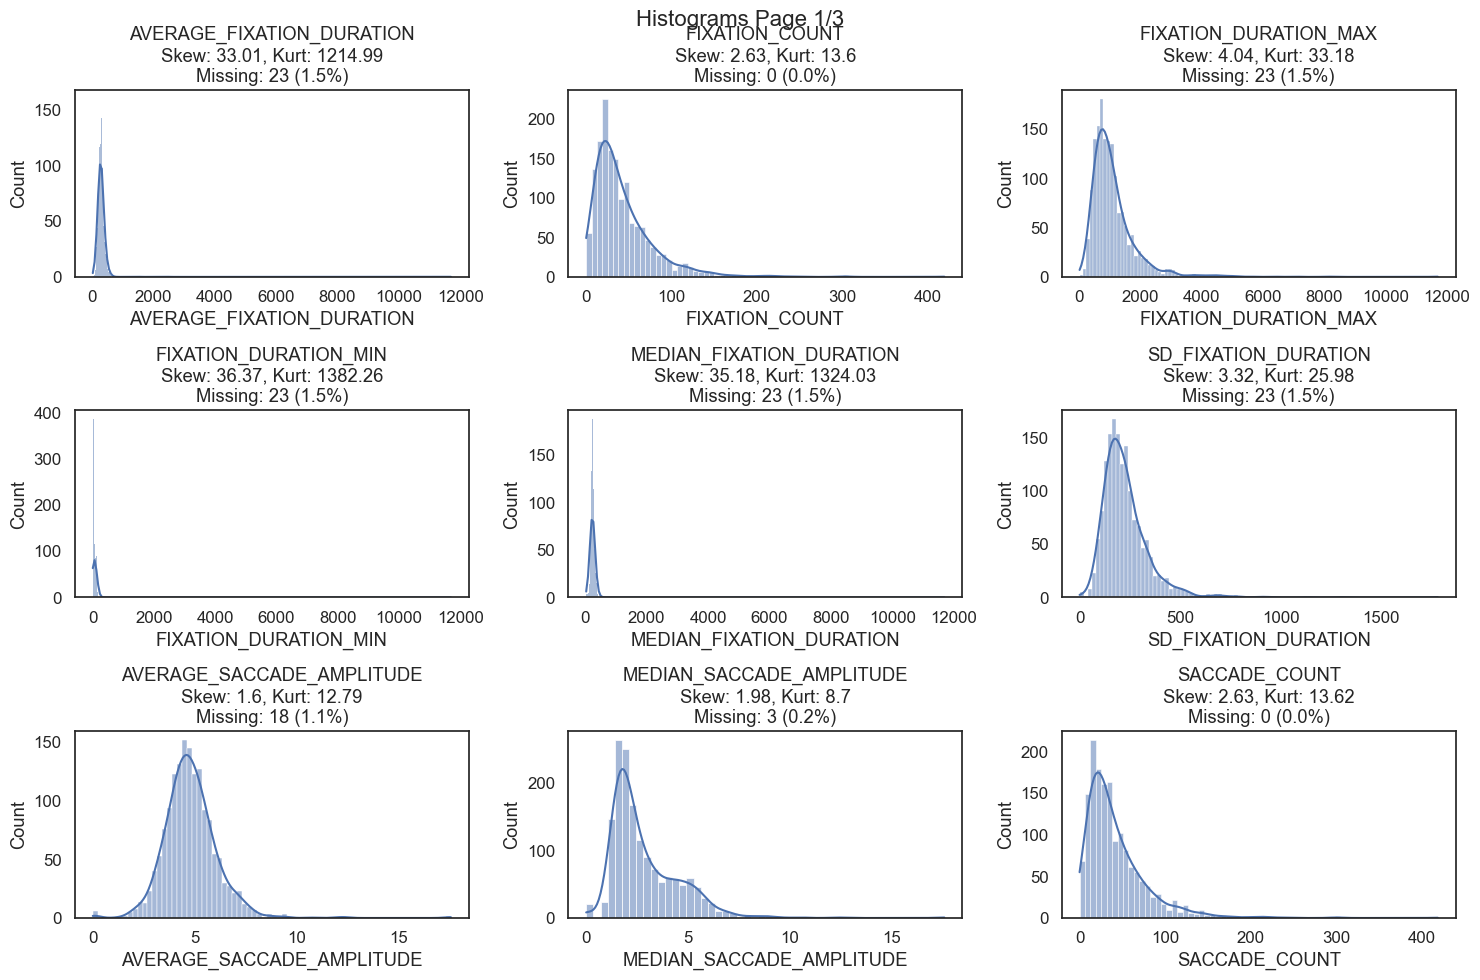

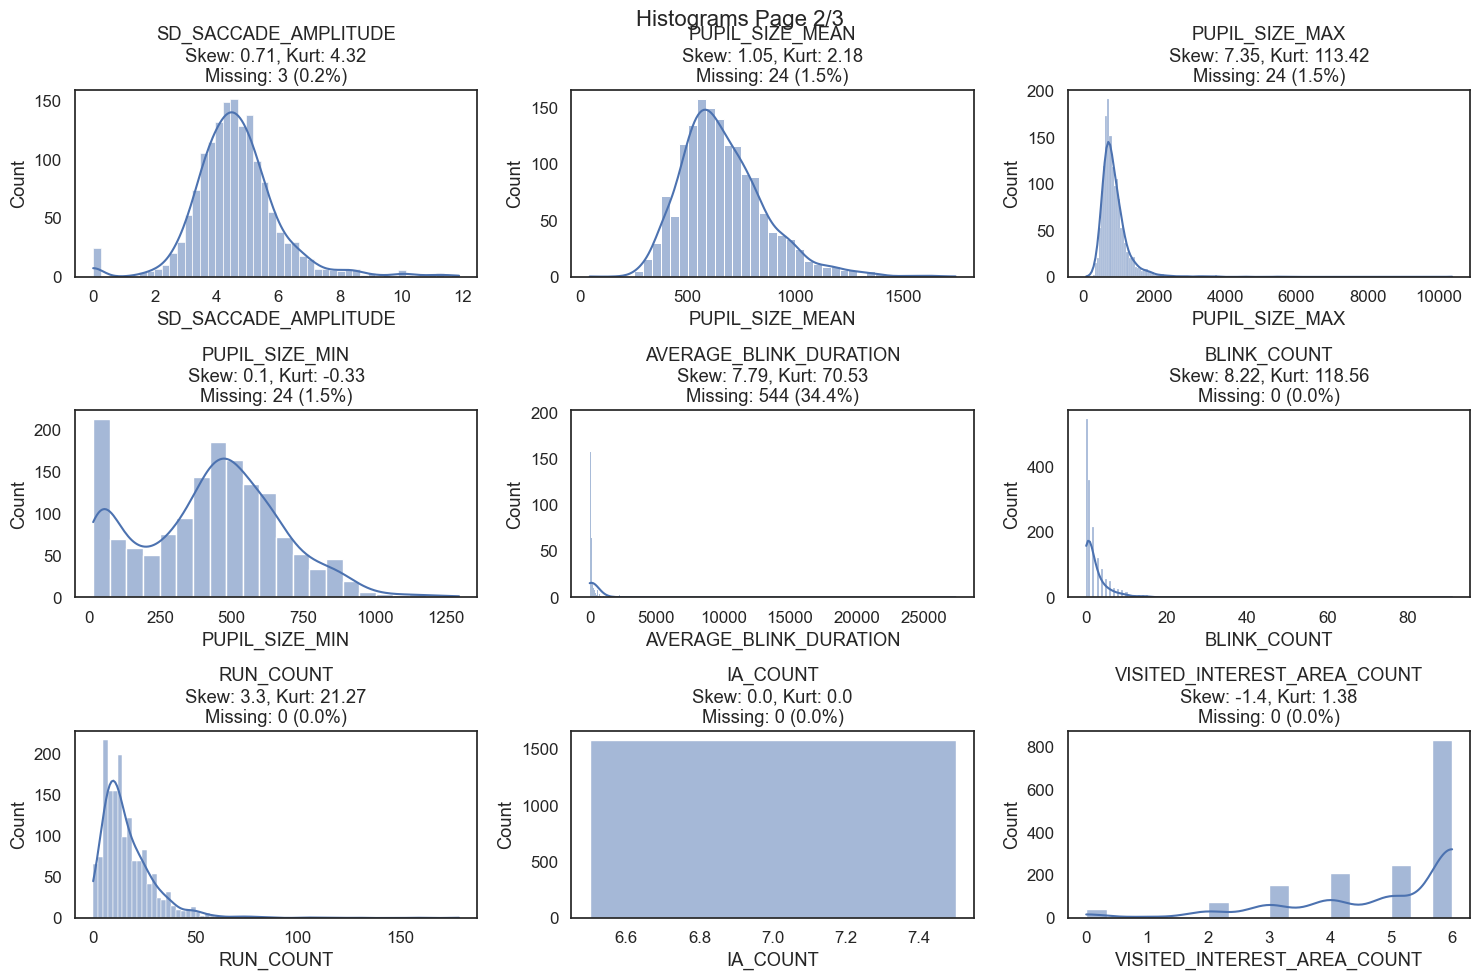

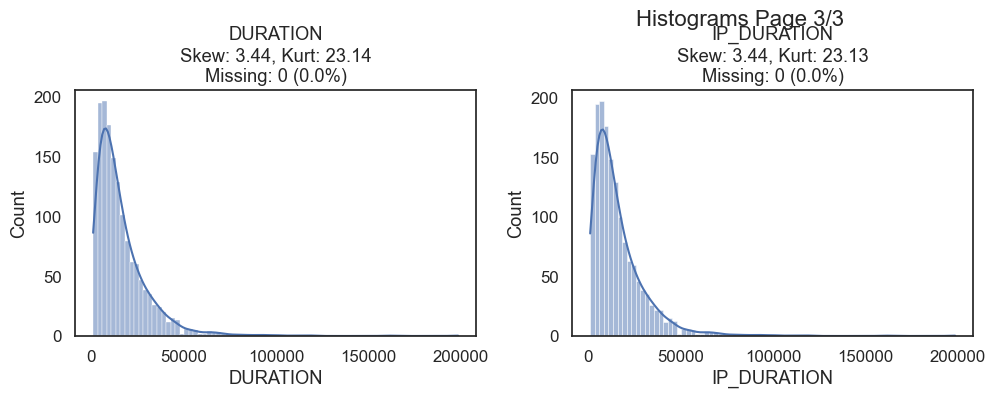

In [272]:
# Select all eye tracking metrics
metrics = [
    "AVERAGE_FIXATION_DURATION",
    "FIXATION_COUNT",
    "FIXATION_DURATION_MAX",
    "FIXATION_DURATION_MIN",
    "MEDIAN_FIXATION_DURATION",
    "SD_FIXATION_DURATION",
    "AVERAGE_SACCADE_AMPLITUDE",
    "MEDIAN_SACCADE_AMPLITUDE",
    "SACCADE_COUNT",
    "SD_SACCADE_AMPLITUDE",
    "PUPIL_SIZE_MEAN",
    "PUPIL_SIZE_MAX",
    "PUPIL_SIZE_MIN",
    "AVERAGE_BLINK_DURATION",
    "BLINK_COUNT",
    "RUN_COUNT",
    "IA_COUNT",
    "VISITED_INTEREST_AREA_COUNT",
    "DURATION",
    "IP_DURATION"
]


# Create a comprehensive descriptive statistics table
def descriptive_stats(df):
    # Filter only numeric columns (both float64 and int64) for statistical calculations
    numeric_df = df[metrics].select_dtypes(include=['float64', 'int64'])

    # Basic statistics
    desc = numeric_df.describe().T
    
    # Add additional statistics
    desc['skewness'] = numeric_df.skew()
    desc['kurtosis'] = numeric_df.kurtosis()
    desc['median'] = numeric_df.median()
    desc['variance'] = numeric_df.var()
    desc['range'] = numeric_df.max() - numeric_df.min()
    desc['IQR'] = numeric_df.quantile(0.75) - numeric_df.quantile(0.25)
    desc['missing'] = numeric_df.isna().sum()
    desc['missing_pct'] = (numeric_df.isna().sum() / len(numeric_df)) * 100
    
    # Round all values to 2 decimal places for better readability
    desc = desc.round(2)
    
    return desc

# Apply the function to your dataframe
descriptive_table = descriptive_stats(df_selected_numeric)

# Display the table
print(descriptive_table)

# Output descriptive table of metrics
descriptive_table.to_csv("../data/eye_tracking_metrics_descriptive.csv", index=True)


# For a more visual representation, you can also create histograms with density plots to visualize skewness
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))


# Get only numeric columns
numeric_columns = df_selected_numeric.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calculate skewness for all numeric columns
skewness_values = df_selected_numeric[numeric_columns].skew()

# Option 1: Show all metrics with multiple pages of plots
def plot_all_histograms(df, columns, plots_per_page=9):
    num_pages = math.ceil(len(columns) / plots_per_page)
    
    for page in range(num_pages):
        plt.figure(figsize=(15, 10))
        start_idx = page * plots_per_page
        end_idx = min((page + 1) * plots_per_page, len(columns))
        
        for i, column in enumerate(columns[start_idx:end_idx]):
            plt.subplot(3, 3, i + 1)
            sns.histplot(df[column].dropna(), kde=True)
            
            # Add multiple statistics to the title
            skew = df[column].skew().round(2)
            kurt = df[column].kurtosis().round(2)
            missing = df[column].isna().sum()
            missing_pct = (missing / len(df) * 100).round(1)
            
            plt.title(f'{column}\nSkew: {skew}, Kurt: {kurt}\nMissing: {missing} ({missing_pct}%)')
            plt.tight_layout()
        
        plt.suptitle(f'Histograms Page {page+1}/{num_pages}', fontsize=16)
        plt.subplots_adjust(top=0.9)
        plt.show()


# Execute one of the functions:
# For all metrics:
plot_all_histograms(df_selected_numeric, metrics)


### Summary of Metric Issues
Several of the selected eye-tracking and behavioral metrics exhibit significant distributional challenges, including high skewness, elevated kurtosis, negative skewness, and evidence of multimodal distributions. These non-normal characteristics can adversely impact machine learning model performance and may lead to unreliable or biased results if not properly addressed.

| Metric                      | Skew | Kurt | Issue         | Solution        |
|-----------------------------|------|------|---------------|-----------------|
| AVG_FIX_DUR                 | 33.0 |1215  | Extreme skew  | Log             |
| FIX_COUNT                   | 2.6  | 14   | Skew/kurt     | Log             |
| FIX_DUR_MAX                 | 4.0  | 33   | Skew/kurt     | Log             |
| FIX_DUR_MIN                 |36.4  |1382  | Extreme skew  | Log             |
| MED_FIX_DUR                 |35.2  |1324  | Extreme skew  | Log             |
| SD_FIX_DUR                  | 3.3  | 26   | Skew/kurt     | Log             |
| AVG_SACC_AMP                | 1.6  | 13   | Mild skew     | Sqrt            |
| MED_SACC_AMP                | 2.0  | 9    | Mild skew     | Sqrt            |
| SACC_COUNT                  | 2.6  | 14   | Skew/kurt     | Log             |
| SD_SACC_AMP                 | 0.7  | 4    | Mild kurt     | OK              |
| PUPIL_MEAN                  | 1.1  | 2    | Slight skew   | OK              |
| PUPIL_MAX                   | 7.4  |113   | Skew/kurt     | Log             |
| PUPIL_MIN                   | 0.1  |-0.3  | None          | OK              |
| AVG_BLINK_DUR               | 7.8  | 71   | Skew/kurt     | Log             |
| BLINK_COUNT                 | 8.2  |119   | Skew/kurt     | Log             |
| RUN_COUNT                   | 3.3  | 21   | Skew/kurt     | Log             |
| IA_COUNT                    | 0.0  | 0    | Constant      | Remove          |
| VISITED_IA_COUNT            |-1.4  | 1.4  | Neg. skew     | Reflect         |
| DURATION                    | 3.4  | 23   | Skew/kurt     | Log             |
| IP_DURATION                 | 3.4  | 23   | Skew/kurt     | Log             |

### Data is df_selected_numeric


In [273]:
# Map for transformations and suffixes
transforms = {
    "AVERAGE_FIXATION_DURATION":     ("log",       lambda x: np.log1p(x)),
    "FIXATION_COUNT":                ("log",       lambda x: np.log1p(x)),
    "FIXATION_DURATION_MAX":         ("log",       lambda x: np.log1p(x)),
    "FIXATION_DURATION_MIN":         ("log",       lambda x: np.log1p(x)),
    "MEDIAN_FIXATION_DURATION":      ("log",       lambda x: np.log1p(x)),
    "SD_FIXATION_DURATION":          ("log",       lambda x: np.log1p(x)),
    "AVERAGE_SACCADE_AMPLITUDE":     ("sqrt",      lambda x: np.sqrt(x)),
    "MEDIAN_SACCADE_AMPLITUDE":      ("sqrt",      lambda x: np.sqrt(x)),
    "SACCADE_COUNT":                 ("log",       lambda x: np.log1p(x)),
    "SD_SACCADE_AMPLITUDE":          (None,        None),        # OK, no action needed
    "PUPIL_SIZE_MEAN":               (None,        None),        # OK, no action needed
    "PUPIL_SIZE_MAX":                ("log",       lambda x: np.log1p(x)),
    "PUPIL_SIZE_MIN":                (None,        None),        # OK, no action needed
    "AVERAGE_BLINK_DURATION":        ("log",       lambda x: np.log1p(x)),
    "BLINK_COUNT":                   ("log",       lambda x: np.log1p(x)),
    "RUN_COUNT":                     ("log",       lambda x: np.log1p(x)),
    "IA_COUNT":                      ("remove",    None),        # Remove
    "VISITED_INTEREST_AREA_COUNT":   ("reflectlog",lambda x: np.log1p(reflect(x))),  # Reflect then log
    "DURATION":                      ("log",       lambda x: np.log1p(x)),
    "IP_DURATION":                   ("log",       lambda x: np.log1p(x)),
}

df_transformed = df_selected_numeric.copy()



def reflect(x):
    return x.max() + 1 - x

for col, (suffix, transform) in transforms.items():
    if col not in df_transformed.columns:
        continue

    if suffix is None:
        continue  # No transformation, keep original
    elif suffix == "remove":
        df_transformed.drop(columns=[col], inplace=True)
    else:
        new_col_name = f"{col}_{suffix}"
        df_transformed[new_col_name] = transform(df_transformed[col])

# keep only transformed columns:
#keep_cols = [f"{col}_{suffix}" for col, (suffix, _) in transforms.items() if suffix not in (None, "remove")]
#df_final = df_transformed[keep_cols]

# View transformed DataFrame
df_transformed.head()


RECORDING_SESSION_LABEL  trialid  response  AVERAGE_FIXATION_DURATION  \
0                ET24_066        4         1                     366.88   
1                ET24_066       12         1                     354.98   
2                ET24_066        1         1                        NaN   
3                ET24_066       18         0                        NaN   
4                ET24_066        6         1                     206.57   

   FIXATION_COUNT  FIXATION_DURATION_MAX  FIXATION_DURATION_MIN  \
0              57                 1011.0                   90.0   
1              57                 1134.0                   36.0   
2               0                    NaN                    NaN   
3               0                    NaN                    NaN   
4               7                  416.0                    8.0   

   MEDIAN_FIXATION_DURATION  SD_FIXATION_DURATION  AVERAGE_SACCADE_AMPLITUDE  \
0                     368.0                198.33                       5.45   
1                     308.0                206.06                       5.54   
2                       NaN                   NaN                      12.28   
3                       NaN                   NaN                      12.40   
4                     234.0                142.05                       8.63   

   MEDIAN_SACCADE_AMPLITUDE  SACCADE_COUNT  SD_SACCADE_AMPLITUDE  \
0                      4.18             56                  4.69   
1                      1.85             57                  5.23   
2                     12.28              1                  0.00   
3                     12.40              1                  0.00   
4                      6.56              7                  5.75   

   PUPIL_SIZE_MEAN  PUPIL_SIZE_MAX  PUPIL_SIZE_MIN  AVERAGE_BLINK_DURATION  \
0           597.68           691.0           530.0                   140.0   
1           580.97           718.0           503.0                   178.0   
2              NaN             NaN             NaN                  5788.0   
3              NaN             NaN             NaN                 13560.0   
4           508.65           527.0           491.0                  7765.0   

   BLINK_COUNT  RUN_COUNT  VISITED_INTEREST_AREA_COUNT  DURATION  IP_DURATION  \
0            3         32                            6     23799        23714   
1            5         26                            6     23699        23619   
2            1          0                            0      5825         5735   
3            1          0                            0     13597        13518   
4            2          5                            5     17349        17270   

   AVERAGE_FIXATION_DURATION_log  FIXATION_COUNT_log  \
0                       5.907757            4.060443   
1                       5.874875            4.060443   
2                            NaN            0.000000   
3                            NaN            0.000000   
4                       5.335469            2.079442   

   FIXATION_DURATION_MAX_log  FIXATION_DURATION_MIN_log  \
0                   6.919684                   4.510860   
1                   7.034388                   3.610918   
2                        NaN                        NaN   
3                        NaN                        NaN   
4                   6.033086                   2.197225   

   MEDIAN_FIXATION_DURATION_log  SD_FIXATION_DURATION_log  \
0                      5.910797                  5.294962   
1                      5.733341                  5.333009   
2                           NaN                       NaN   
3                           NaN                       NaN   
4                      5.459586                  4.963194   

   AVERAGE_SACCADE_AMPLITUDE_sqrt  MEDIAN_SACCADE_AMPLITUDE_sqrt  \
0                        2.334524                       2.044505   
1                        2.353720                       1.360147   
2                        3.504283      

## Descriptive summary after transformation

                                         count        mean         std  \
AVERAGE_FIXATION_DURATION_log           1559.0    5.684923    0.306911   
FIXATION_COUNT_log                      1582.0    3.474602    0.855799   
FIXATION_DURATION_MAX_log               1559.0    6.866475    0.548522   
FIXATION_DURATION_MIN_log               1559.0    3.867271    0.773623   
MEDIAN_FIXATION_DURATION_log            1559.0    5.443176    0.304428   
SD_FIXATION_DURATION_log                1559.0    5.311169    0.542014   
AVERAGE_SACCADE_AMPLITUDE_sqrt          1564.0    2.168823    0.308255   
MEDIAN_SACCADE_AMPLITUDE_sqrt           1579.0    1.617905    0.474758   
SACCADE_COUNT_log                       1582.0    3.454023    0.838961   
SD_SACCADE_AMPLITUDE                    1579.0    4.642888    1.446659   
PUPIL_SIZE_MEAN                         1558.0  666.448543  200.861462   
PUPIL_SIZE_MAX_log                      1558.0    6.710114    0.372079   
PUPIL_SIZE_MIN                        

<Figure size 1500x1000 with 0 Axes>

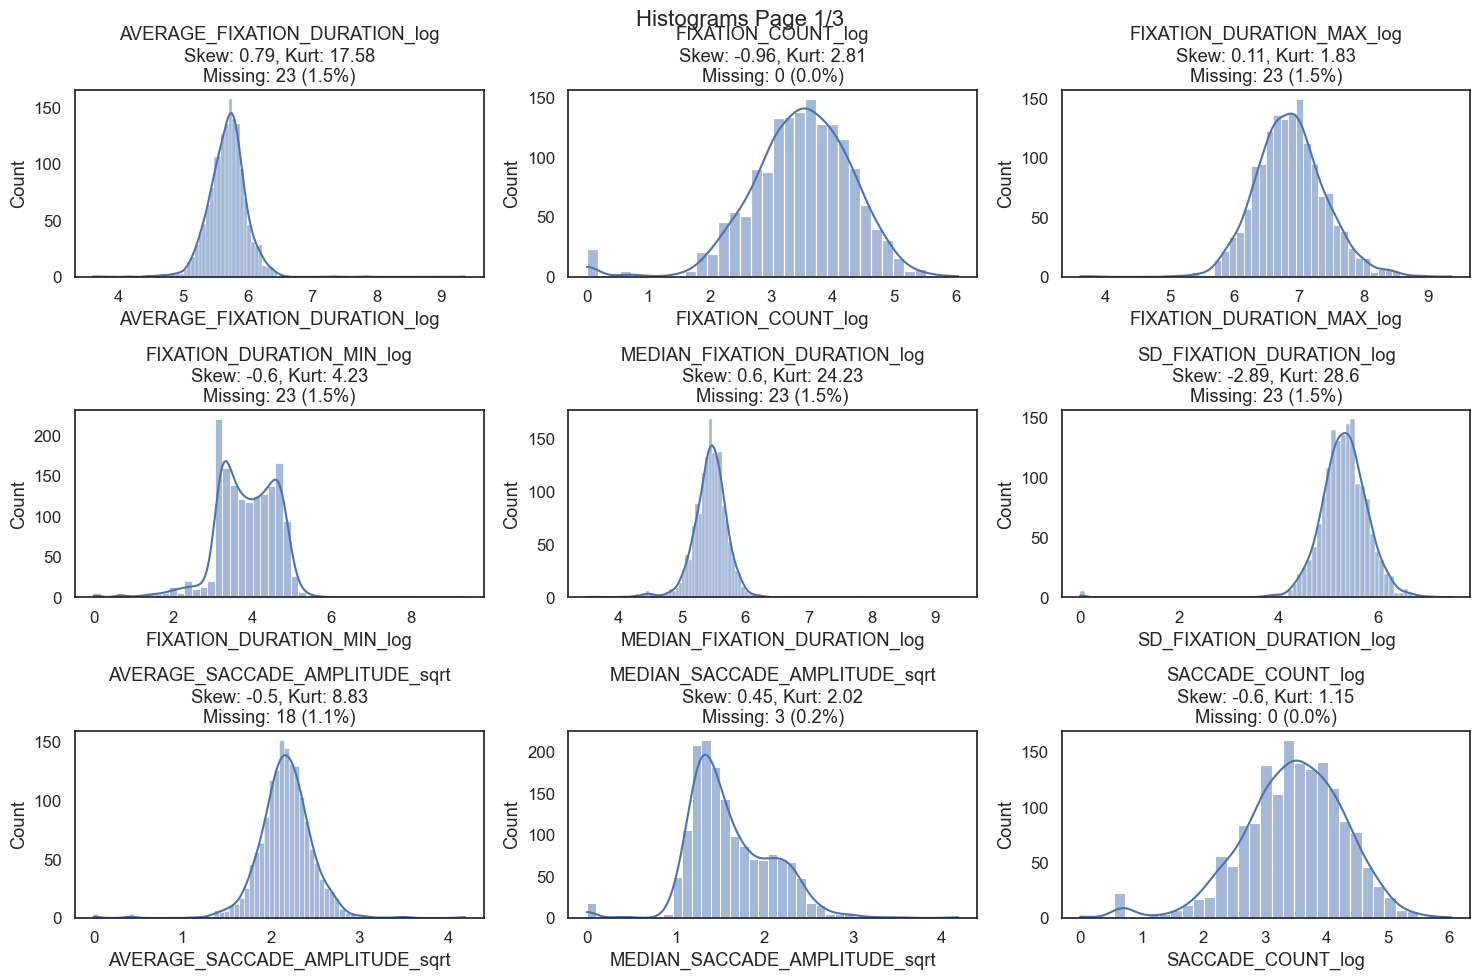

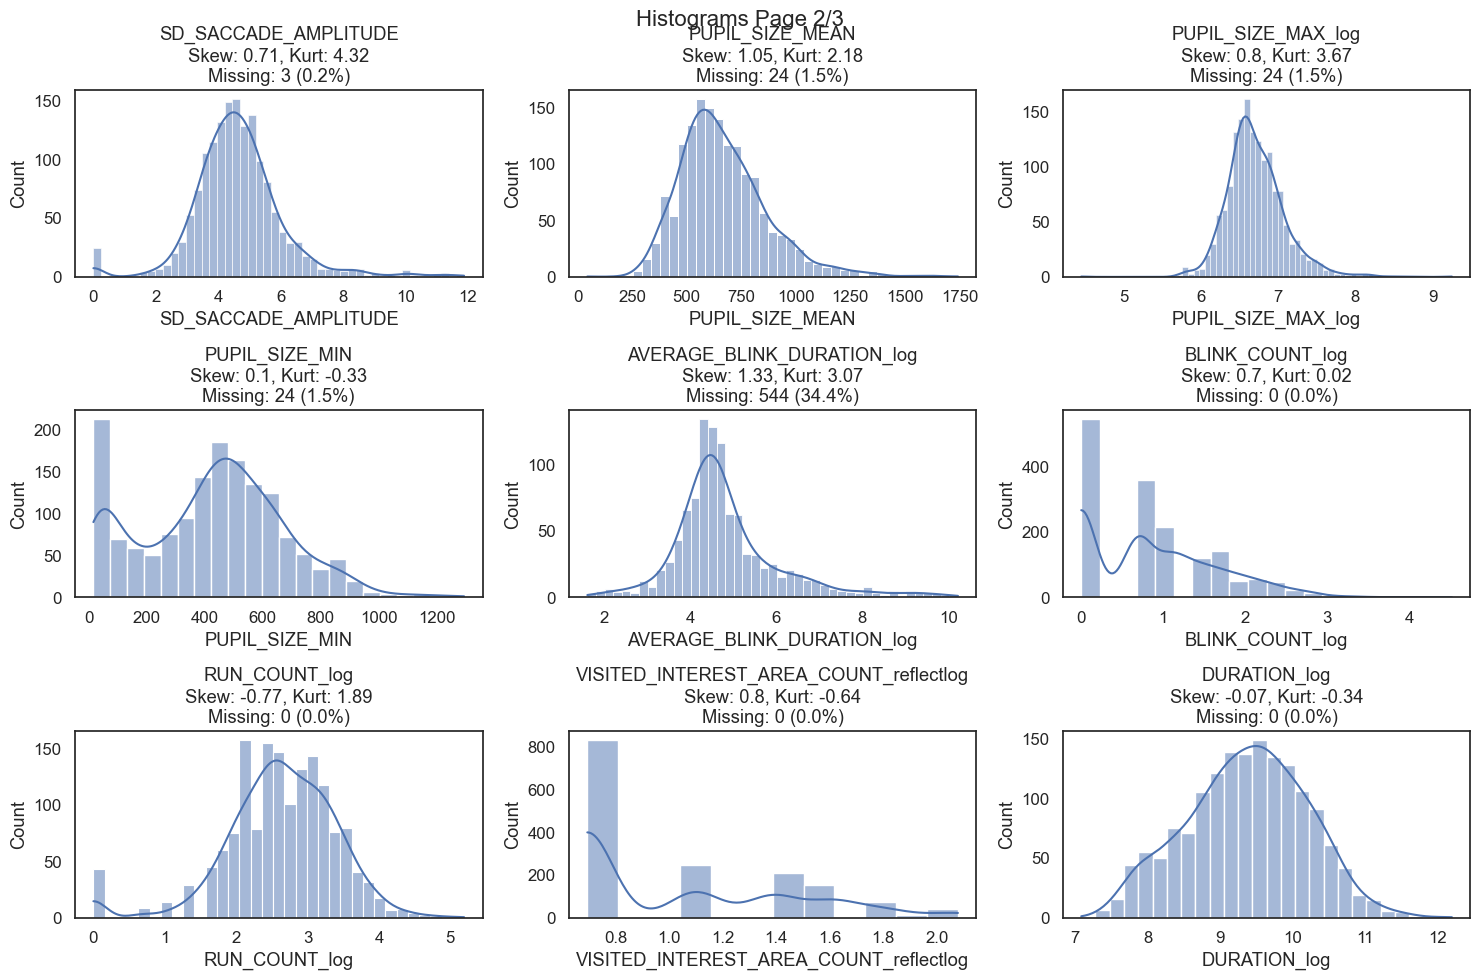

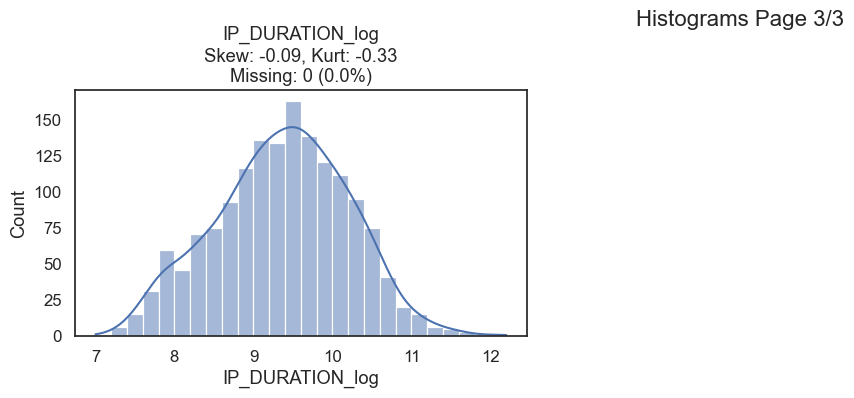

In [274]:
# List of new transformed variables
transformed_vars = [
    "AVERAGE_FIXATION_DURATION_log",
    "FIXATION_COUNT_log",
    "FIXATION_DURATION_MAX_log",
    "FIXATION_DURATION_MIN_log",
    "MEDIAN_FIXATION_DURATION_log",
    "SD_FIXATION_DURATION_log",
    "AVERAGE_SACCADE_AMPLITUDE_sqrt",
    "MEDIAN_SACCADE_AMPLITUDE_sqrt",
    "SACCADE_COUNT_log",
    "SD_SACCADE_AMPLITUDE",
    "PUPIL_SIZE_MEAN", 
    "PUPIL_SIZE_MAX_log",
    "PUPIL_SIZE_MIN",
    "AVERAGE_BLINK_DURATION_log",
    "BLINK_COUNT_log",
    "RUN_COUNT_log",
    "VISITED_INTEREST_AREA_COUNT_reflectlog",
    "DURATION_log",
    "IP_DURATION_log"
]

def descriptive_stats(df):
    # Filter only numeric columns (both float64 and int64) for statistical calculations
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    
    # Basic statistics
    desc = numeric_df.describe().T
    desc['skewness'] = numeric_df.skew()
    desc['kurtosis'] = numeric_df.kurtosis()
    return desc

# Apply the function to your dataframe
descriptive_table_transformed = descriptive_stats(df_transformed[transformed_vars])

# Display the table
print(descriptive_table_transformed)

# Output descriptive table of metrics
descriptive_table_transformed.to_csv("../data/eye_tracking_metrics_descriptive_transformed.csv", index=True)


# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Get only numeric columns
numeric_columns = df_transformed.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calculate skewness for all numeric columns
skewness_values = df_transformed[transformed_vars].skew()


# Execute one of the functions:
# For all metrics:
plot_all_histograms(df_transformed, transformed_vars)

## Standardization

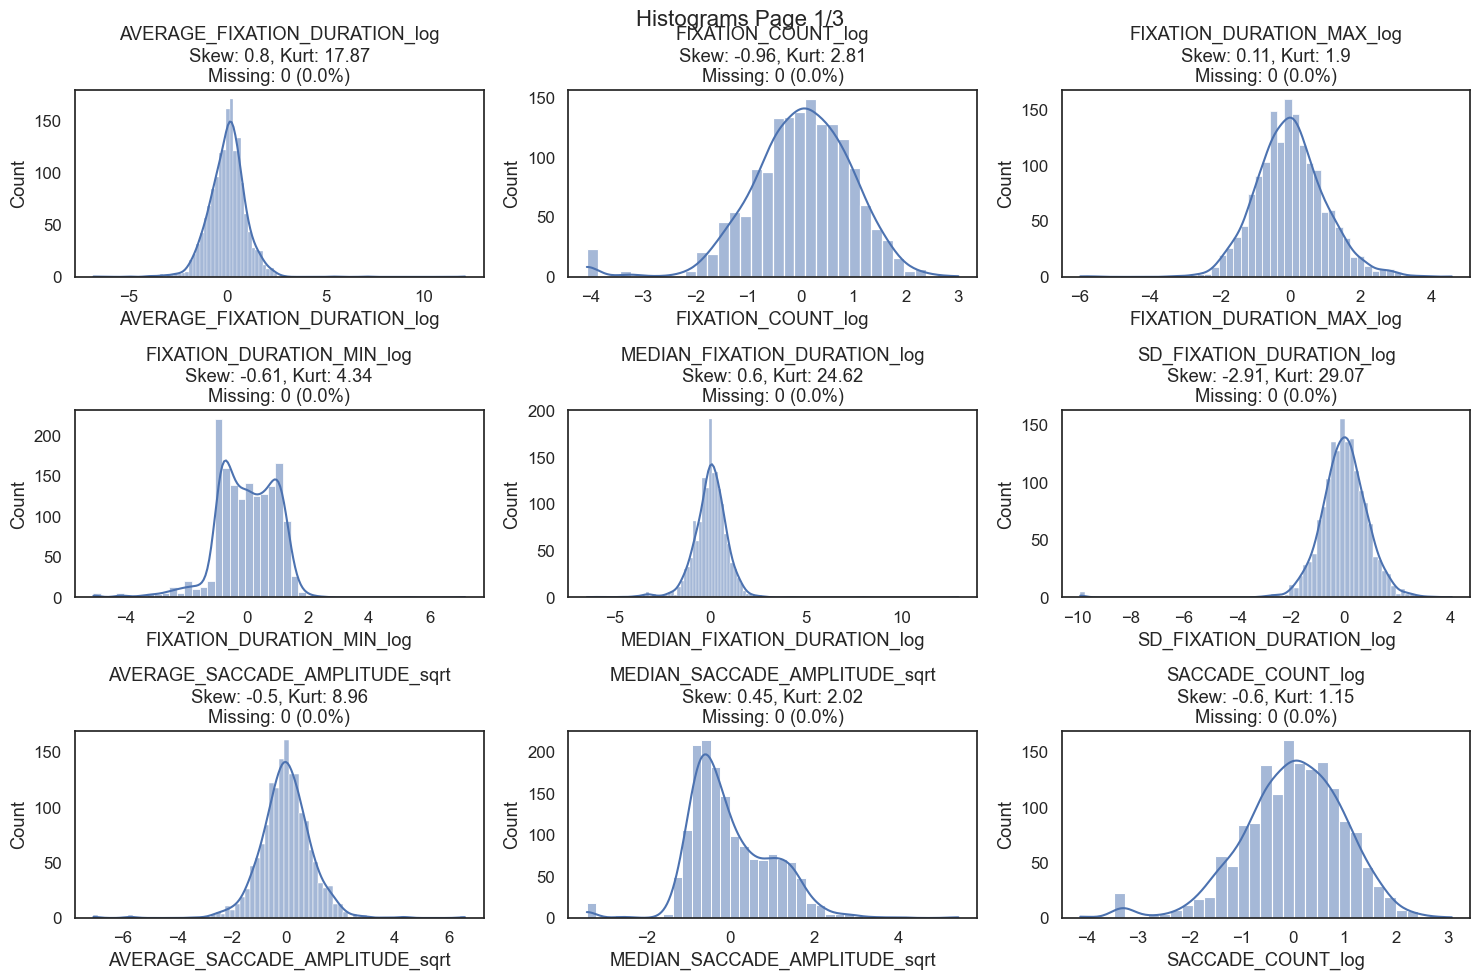

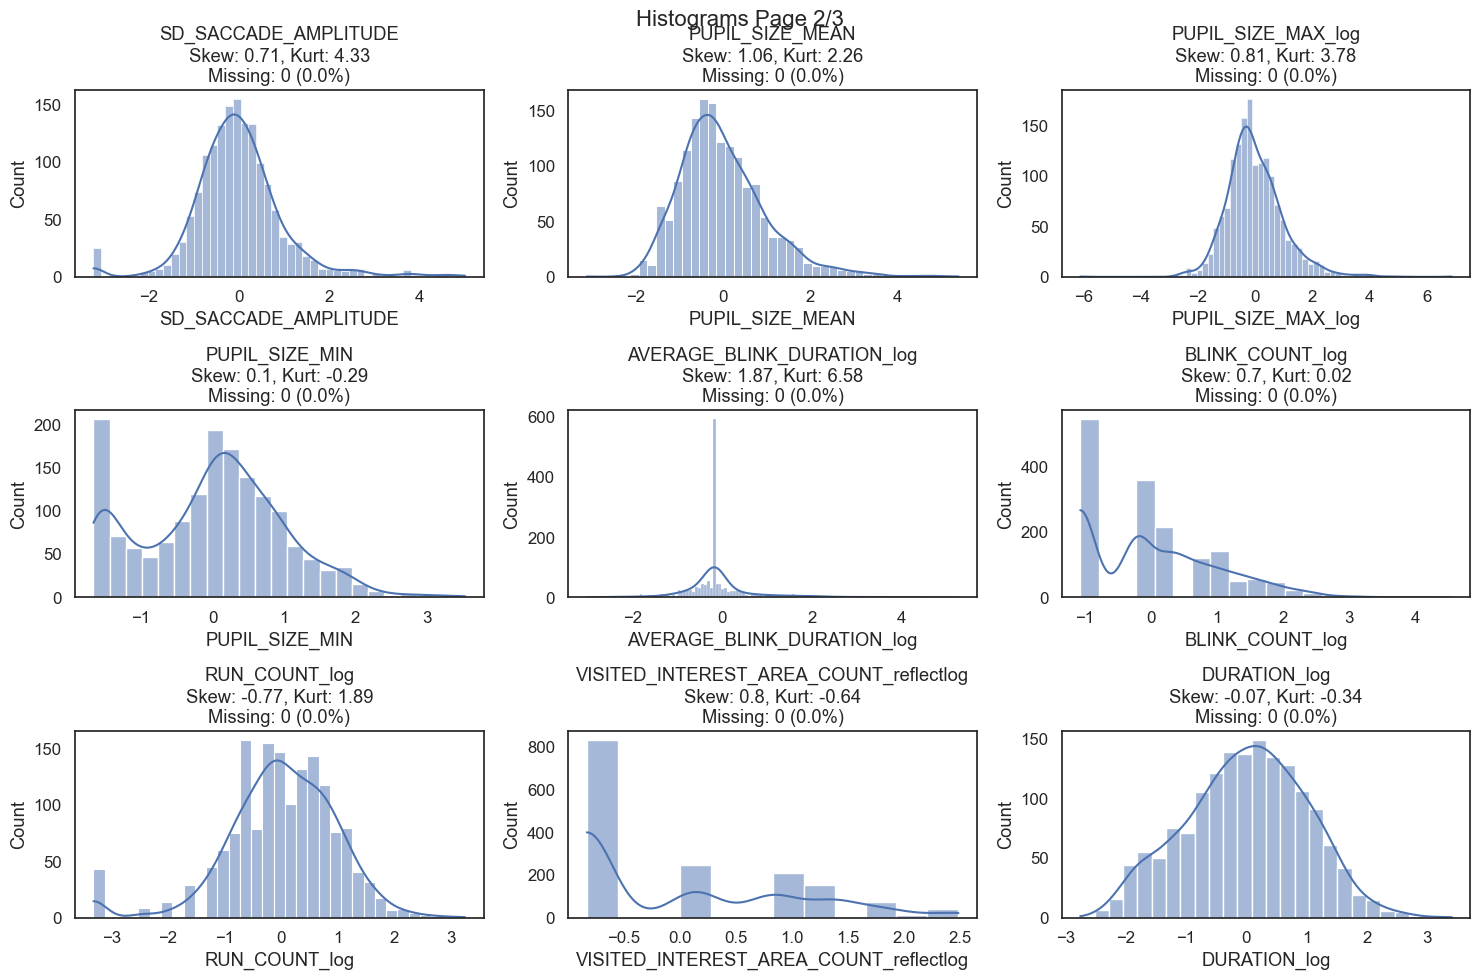

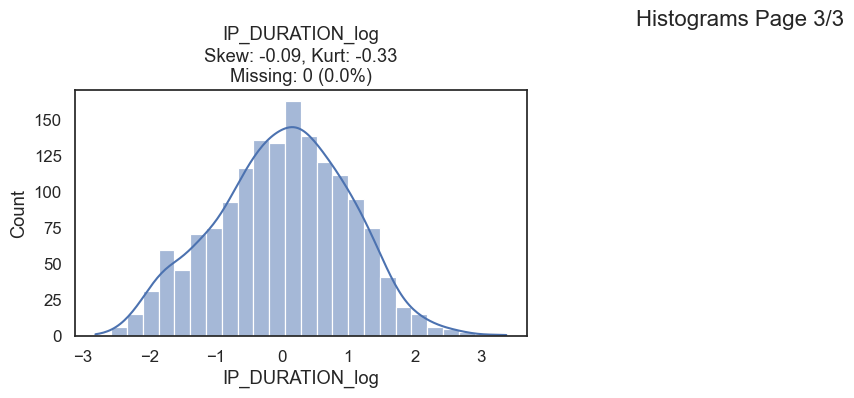

In [275]:
# Decide on imputation strategy (mean/median imputation, KNN, model-based)

# Create a copy for imputation
df_fill = df_transformed.copy()

# Impute missing values
df_fill[transformed_vars] = df_fill[transformed_vars].fillna(df_fill[transformed_vars].median())

# Create a new copy for standardization
df_standardized = df_fill.copy()

# Standardize the selected columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_standardized[transformed_vars] = scaler.fit_transform(df_fill[transformed_vars])

# Plot histograms (fix variable name typo)
plot_all_histograms(df_standardized, transformed_vars)


### Feature Selection or Dimensionality Reduction

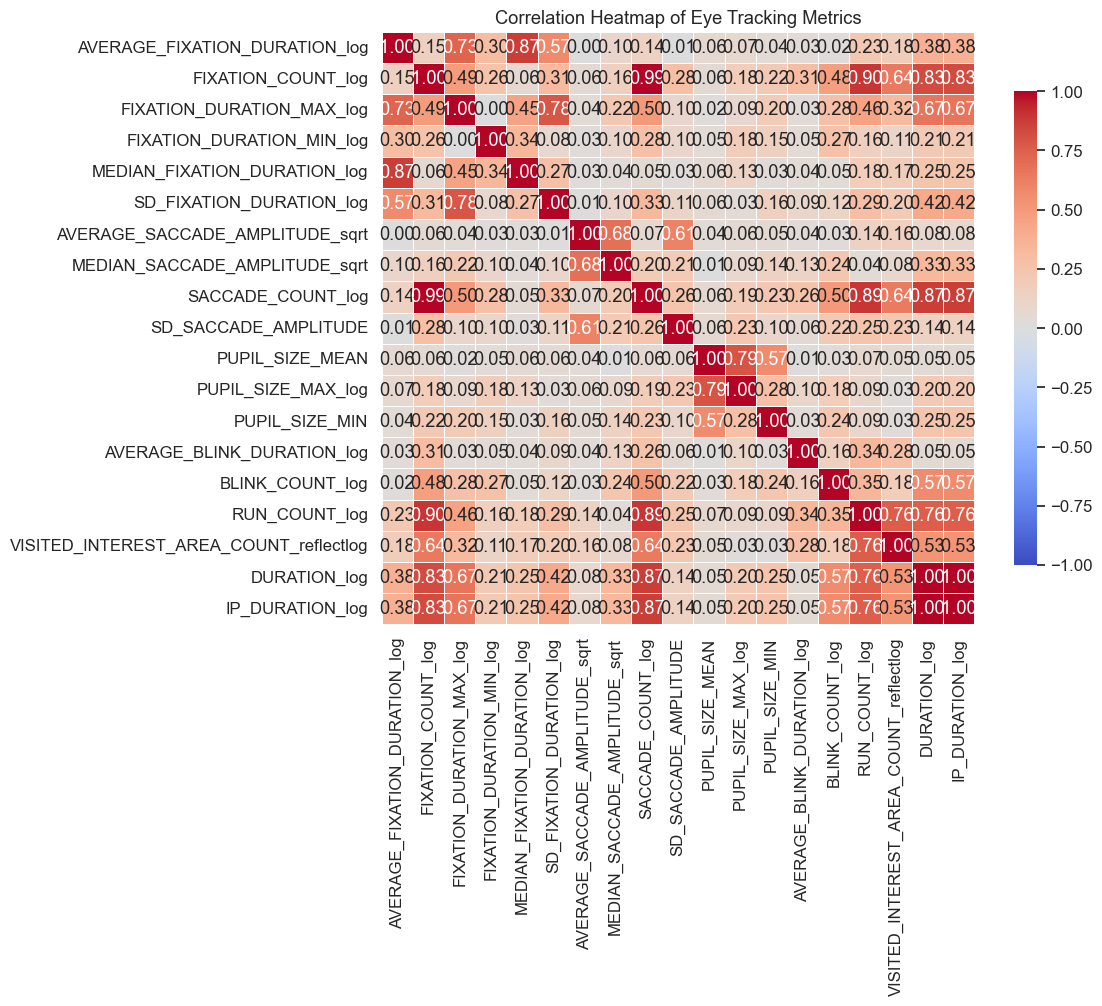

['FIXATION_DURATION_MAX_log', 'MEDIAN_FIXATION_DURATION_log', 'SD_FIXATION_DURATION_log', 'SACCADE_COUNT_log', 'PUPIL_SIZE_MAX_log', 'RUN_COUNT_log', 'VISITED_INTEREST_AREA_COUNT_reflectlog', 'DURATION_log', 'IP_DURATION_log']


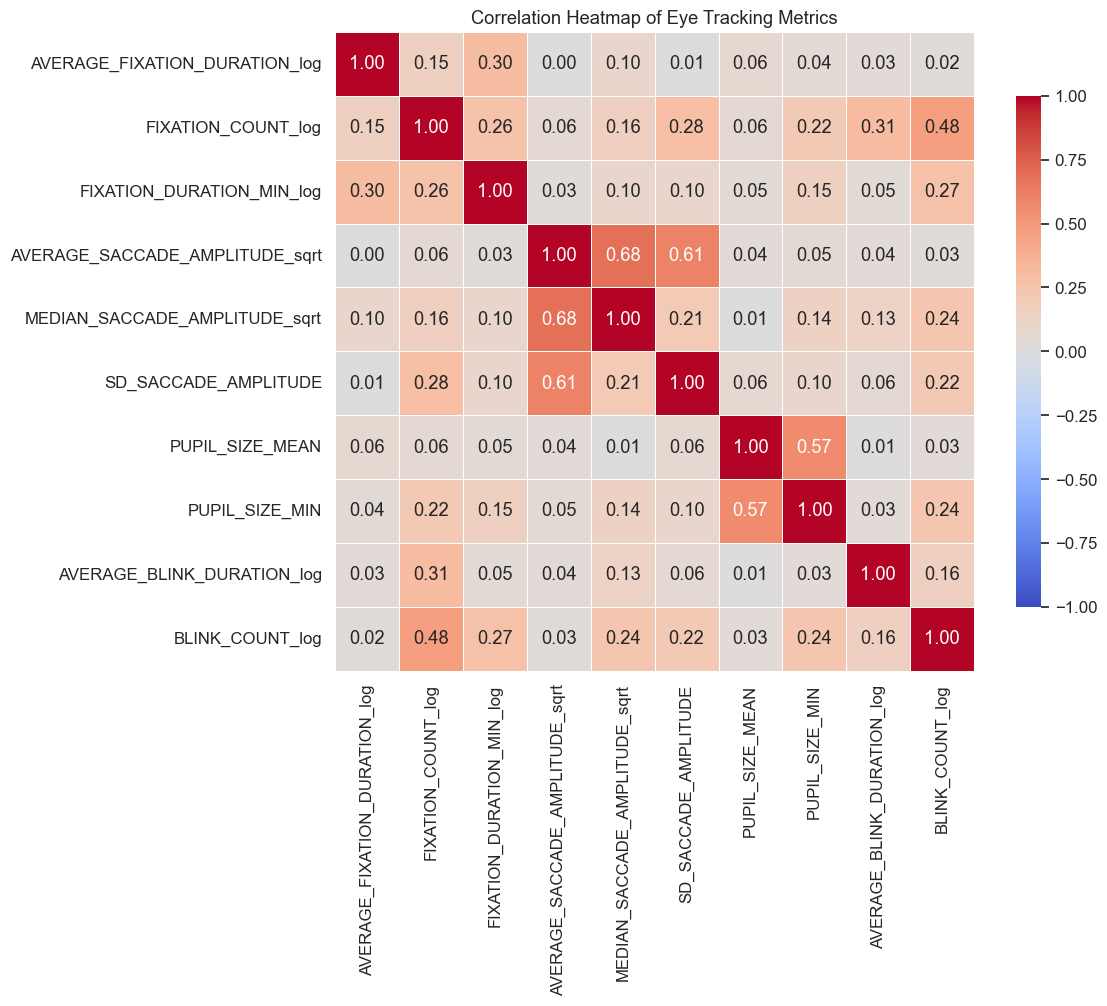

In [276]:
# Use only numeric columns for correlation calculation:
corr_matrix = df_standardized[transformed_vars].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))


#to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]


# Drop from df_standardized (numeric part only)
df_final = df_standardized.drop(columns=to_drop)



plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,           # Set to False for cleaner look if many variables
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5,
    square=True,
    cbar_kws={'shrink': 0.8}
)
plt.title("Correlation Heatmap of Eye Tracking Metrics")
plt.tight_layout()
plt.show()


print(to_drop)
after_cor_checking_vars = [col for col in transformed_vars if col not in to_drop]


corr_matrix = df_standardized[after_cor_checking_vars].corr().abs()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,           # Set to False for cleaner look if many variables
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5,
    square=True,
    cbar_kws={'shrink': 0.8}
)
plt.title("Correlation Heatmap of Eye Tracking Metrics")
plt.tight_layout()
plt.show()


### PCA (Principal Component Analysis)

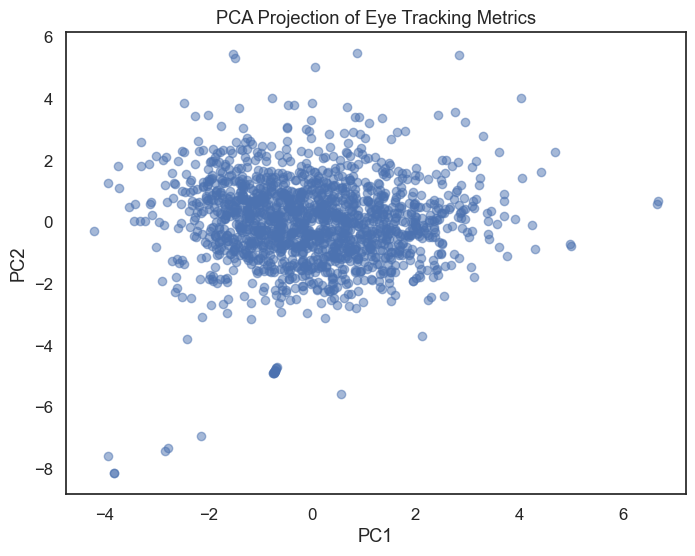

In [277]:
# Now run PCA using the available columns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=4)
X_pca = pca.fit_transform(df_standardized[after_cor_checking_vars])

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection of Eye Tracking Metrics")
plt.show()


### Exploratory Data Analysis (EDA)

### Unsupervised: Cluster analysis (K-means, hierarchical, DBSCAN), PCA, t-SNE, UMAP.

### t-SNE Visualization

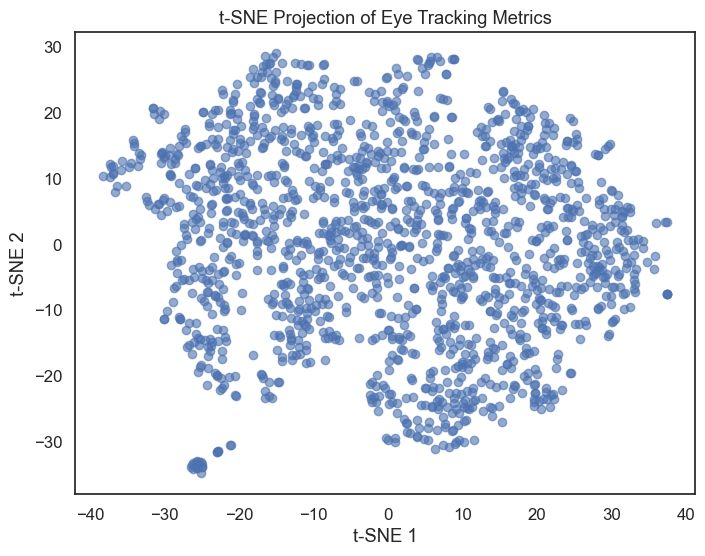

In [278]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Fit t-SNE (may take 1-2 minutes for large datasets)
tsne = TSNE(n_components=2, perplexity=45, random_state=0)
X_tsne = tsne.fit_transform(df_standardized[after_cor_checking_vars])

# Plot
plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], alpha=0.6)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Projection of Eye Tracking Metrics")
plt.show()



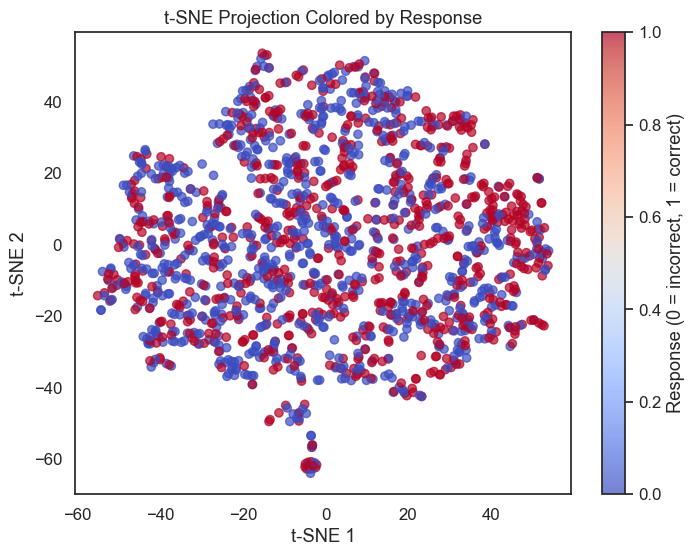

In [279]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Fit t-SNE
tsne = TSNE(n_components=2, perplexity=20, random_state=0)
X_tsne = tsne.fit_transform(df_standardized[after_cor_checking_vars])

# Plot, colored by response
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=df_standardized['response'],  # Color by response variable (0 or 1)
    cmap='coolwarm',
    alpha=0.7
)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Projection Colored by Response")
plt.colorbar(label='Response (0 = incorrect, 1 = correct)')
plt.show()


The red and blue points (correct vs. incorrect responses) are scattered and overlap significantly.
This suggests that eye movement features alone may not clearly separate correct from incorrect responses in a purely unsupervised or low-dimensional projection.
However, some sub-regions show slight concentration of one class, hinting at non-linear patterns.


Shallow models or linear classifiers might struggle.

Consider:

✅ Tree-based models (Random Forests, XGBoost)
✅ Neural nets or SVM with kernels
✅ Combining eye-tracking features with item difficulty or participant ability (e.g., from IRT models)

### Combining eye-tracking features with parameters in IRT model

We use R to fit the Rasch model and input the data from R.
The data includes:
    abilities (theta): ../output/person_abilities_id.csv
    item parameters: ../output/item_parameters_trailid.csv

In [280]:
#df_standardized
# Load IRT outputs
abilities = pd.read_csv("../output/person_abilities_id.csv", index_col=0)
item_params = pd.read_csv("../output/item_parameters_trailid.csv", index_col=0)

# Merge ability scores to eye-tracking data
merged_df = df_standardized.merge(abilities, left_on='RECORDING_SESSION_LABEL', right_index=True)
#merged_df = df_selected_numeric.merge(abilities, left_on='RECORDING_SESSION_LABEL', right_index=True)


# If you have trial-level data, merge item difficulty
merged_df = merged_df.merge(item_params[['a', 'b']], left_on='trialid', right_index=True)


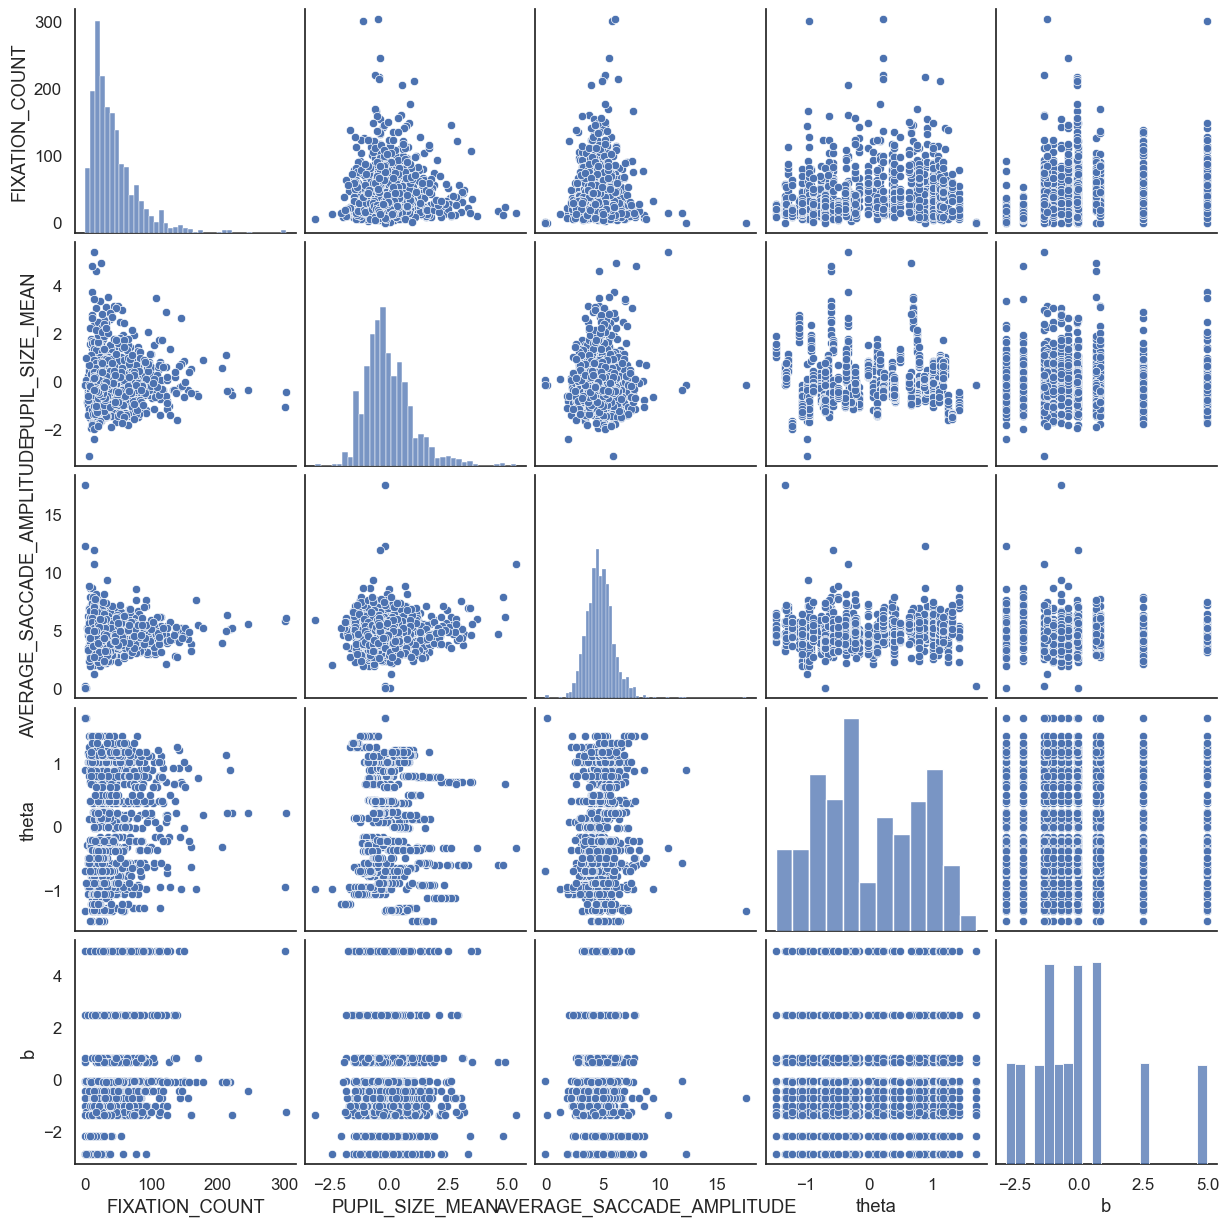

In [281]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
features = ['FIXATION_COUNT', 'PUPIL_SIZE_MEAN', 'AVERAGE_SACCADE_AMPLITUDE', 'theta']
sns.pairplot(merged_df[features + ['b']]) 
plt.show()


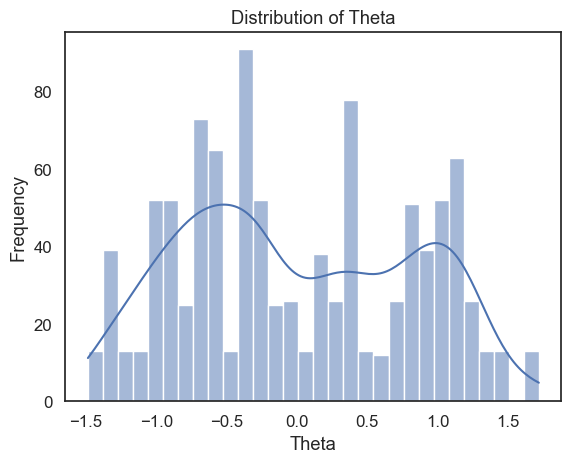

In [282]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(merged_df['theta'], kde=True, bins=30)
plt.title('Distribution of Theta')
plt.xlabel('Theta')
plt.ylabel('Frequency')
plt.show()


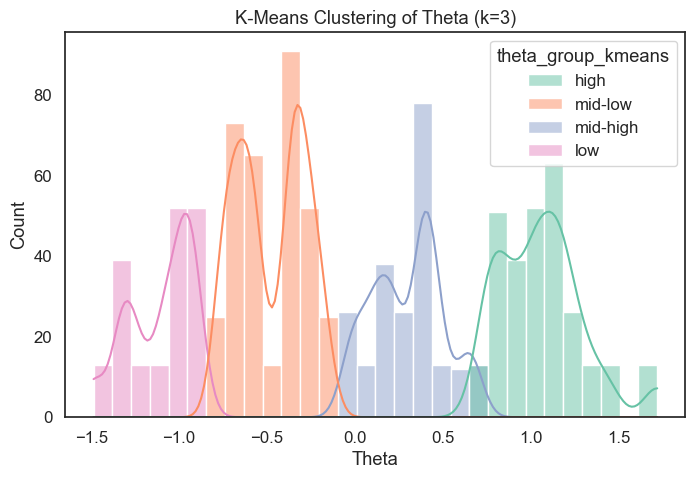

In [283]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Extract and standardize theta ---
theta_values = merged_df[['theta']].dropna()
scaler = StandardScaler()
theta_scaled = scaler.fit_transform(theta_values)

# --- Step 2: Apply K-means clustering ---
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
clusters = kmeans.fit_predict(theta_scaled)
merged_df.loc[theta_values.index, 'theta_cluster'] = clusters

# --- Step 3: Reorder cluster labels based on mean theta ---
cluster_order = (
    merged_df.groupby('theta_cluster')['theta']
    .mean()
    .sort_values()
    .index.tolist()
)
cluster_map = {old: new for new, old in enumerate(cluster_order)}
merged_df['theta_cluster'] = merged_df['theta_cluster'].map(cluster_map)

# --- Step 4: Map cluster indices to ability labels ---
#label_map = {0: 'low', 1: 'mid', 2: 'high'}  # use 3 groups only
label_map = {0: 'low', 1: 'mid-low', 2: 'mid-high', 3: 'high'}  # use 4 groups only
merged_df['theta_group_kmeans'] = merged_df['theta_cluster'].map(label_map)

# --- Step 5: Visualize distribution of theta by cluster ---
plt.figure(figsize=(8, 5))
sns.histplot(data=merged_df, x='theta', hue='theta_group_kmeans',
             bins=30, kde=True, palette='Set2')
plt.title("K-Means Clustering of Theta (k=3)")
plt.xlabel("Theta")
plt.ylabel("Count")
plt.show()


In [284]:
from sklearn.metrics import silhouette_score

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(theta_scaled)
    score = silhouette_score(theta_scaled, labels)
    print(f"Silhouette Score for k={k}: {score:.3f}")


Silhouette Score for k=2: 0.657
Silhouette Score for k=3: 0.594
Silhouette Score for k=4: 0.602
Silhouette Score for k=5: 0.576


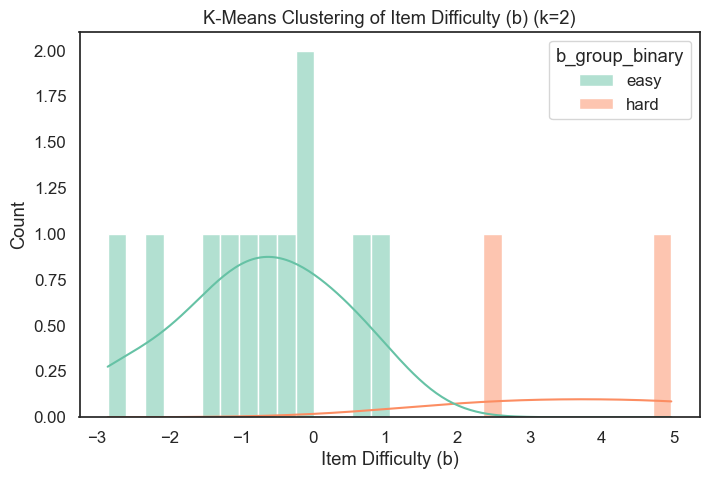

In [285]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Step 1: Get item difficulty values
b_values = merged_df[['trialid', 'b']].drop_duplicates().set_index('trialid')
b_scaled = StandardScaler().fit_transform(b_values)

# Step 2: K-means with k=2
kmeans_b = KMeans(n_clusters=2, n_init=10, random_state=42)
clusters_b = kmeans_b.fit_predict(b_scaled)

# Step 3: Sort and relabel: lower b = easy (0), higher b = hard (1)
cluster_order_b = b_values.groupby(clusters_b)['b'].mean().sort_values().index.tolist()
cluster_map_b = {old: new for new, old in enumerate(cluster_order_b)}
b_values['b_cluster_2'] = pd.Series(clusters_b, index=b_values.index).map(cluster_map_b)

# Step 4: Rename to binary group labels
b_values['b_group_binary'] = b_values['b_cluster_2'].map({0: 'easy', 1: 'hard'})

# Step 5: Merge back into merged_df
merged_df = merged_df.merge(b_values[['b_group_binary']], left_on='trialid', right_index=True, how='left')

# Step 6: Visualize
plt.figure(figsize=(8, 5))
sns.histplot(data=b_values, x='b', hue='b_group_binary', bins=30, kde=True, palette='Set2')
plt.title("K-Means Clustering of Item Difficulty (b) (k=2)")
plt.xlabel("Item Difficulty (b)")
plt.ylabel("Count")
plt.show()


In [286]:
from sklearn.metrics import silhouette_score

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(b_scaled)
    score = silhouette_score(b_scaled, labels)
    print(f"Silhouette Score for k={k}: {score:.3f}")


Silhouette Score for k=2: 0.643
Silhouette Score for k=3: 0.455
Silhouette Score for k=4: 0.457
Silhouette Score for k=5: 0.448


Silhouette Score for k=2: 0.711
Silhouette Score for k=3: 0.582
Silhouette Score for k=4: 0.650
Silhouette Score for k=5: 0.709


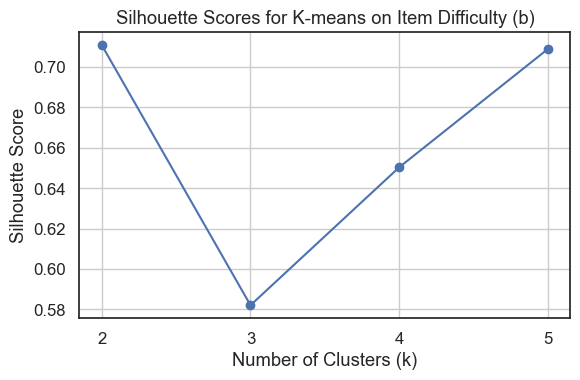

In [287]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# Ensure b-values are in a clean numeric format
b_values = merged_df['b'].dropna().values.reshape(-1, 1)

# Standardize
scaler = StandardScaler()
b_scaled = scaler.fit_transform(b_values)

# Try multiple k values
silhouette_scores = []
k_values = range(2, 6)  # Try k=2 to 5

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(b_scaled)
    score = silhouette_score(b_scaled, labels)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k={k}: {score:.3f}")

# Plot
plt.figure(figsize=(6, 4))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for K-means on Item Difficulty (b)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()


In [288]:
# Step 1: Define group labels
# def ability_group(theta):
#     if theta < -0.5:
# #    if theta < 0:
#         return 'low'
#     elif theta > 0.5:
# #    elif theta >= 0:
#         return 'high'
#     else:
#         return 'mid'



# def difficulty_group(b):
# #    if b < -0.5:
#     if b < 1:
#         return 'easy'
# #    elif b > 0.5:
#     elif b >= 1:
#         return 'hard'
#     else:
#         return 'moderate'

def difficulty_group(b):
    if b < -0.5:
        return 'easy'
    elif b > 0.5:
        return 'hard'
    else:
        return 'moderate'



# Apply grouping
#merged_df['ability_group'] = merged_df['theta'].apply(ability_group)
merged_df['ability_group'] = merged_df['theta_group_kmeans']

merged_df['difficulty_group'] = merged_df['b'].apply(difficulty_group)

In [289]:
merged_df['difficulty_group'].unique()

array(['easy', 'moderate', 'hard'], dtype=object)

In [290]:
from sklearn.metrics import silhouette_score

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(theta_scaled)
    score = silhouette_score(theta_scaled, labels)
    print(f"Silhouette Score for k={k}: {score:.3f}")


Silhouette Score for k=2: 0.657
Silhouette Score for k=3: 0.594
Silhouette Score for k=4: 0.602
Silhouette Score for k=5: 0.576


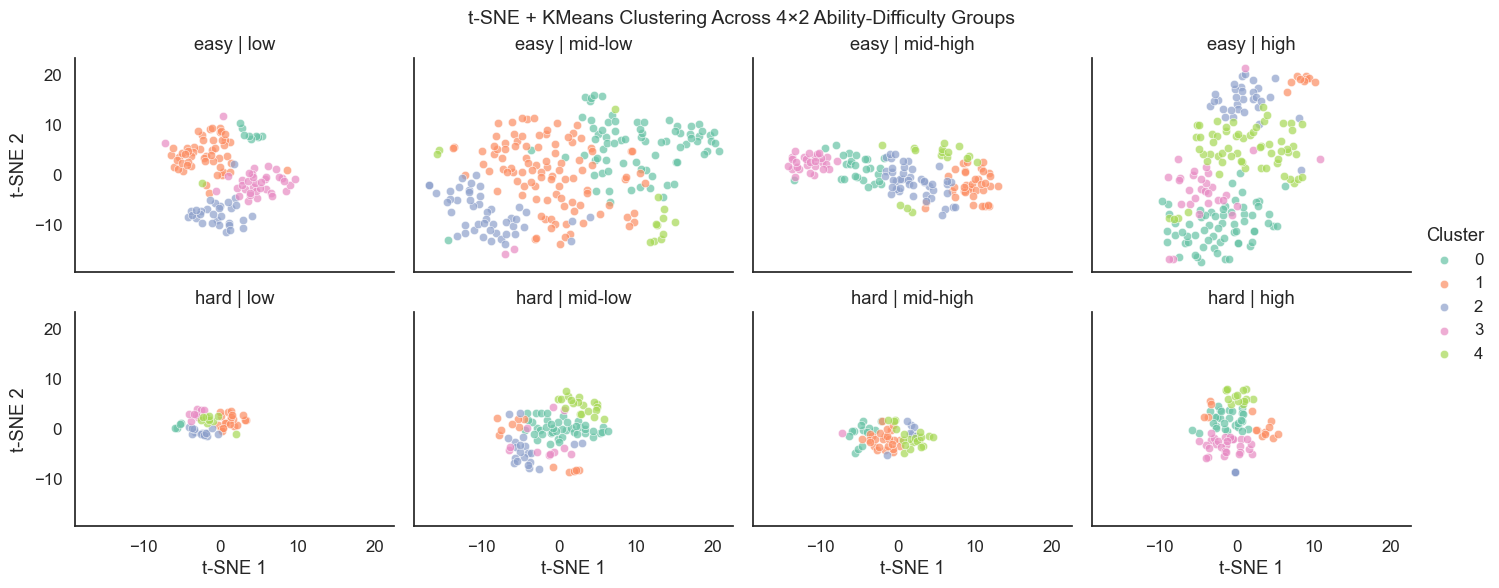

In [291]:
# ------------------------
# Step 1: Define difficulty group
# ------------------------
def difficulty_group(b):
    return 'easy' if b < 0 else 'hard'

# Apply grouping
merged_df['difficulty_group'] = merged_df['b'].apply(difficulty_group)

# Use the KMeans-based 4-level theta group
# Assumes theta_cluster and theta_group_kmeans already exist
merged_df['ability_group'] = merged_df['theta_group_kmeans']

# ------------------------
# Step 2: Prepare columns
# ------------------------
merged_df['tSNE1'] = None
merged_df['tSNE2'] = None
merged_df['Cluster'] = None

# ------------------------
# Step 3: Features for clustering
# ------------------------
features = transformed_vars  # already defined list of eye-tracking features

# ------------------------
# Step 4: Loop over 4 × 2 groups
# ------------------------
for ability in ['low', 'mid-low', 'mid-high', 'high']:
    for difficulty in ['easy', 'hard']:
        mask = (merged_df['ability_group'] == ability) & (merged_df['difficulty_group'] == difficulty)
        subset = merged_df.loc[mask, features].dropna()

        if len(subset) < 5:
            continue  # skip small groups

        # Run t-SNE
        tsne = TSNE(n_components=2, perplexity=25, random_state=42)
        X_tsne = tsne.fit_transform(subset)

        # Run KMeans (within-group clustering)
        kmeans = KMeans(n_clusters=5, random_state=42)
        cluster_labels = kmeans.fit_predict(subset)

        # Get corresponding original indices
        valid_idx = merged_df.loc[mask].dropna(subset=features).index

        # Store results
        merged_df.loc[valid_idx, 'tSNE1'] = X_tsne[:, 0]
        merged_df.loc[valid_idx, 'tSNE2'] = X_tsne[:, 1]
        merged_df.loc[valid_idx, 'Cluster'] = cluster_labels

# ------------------------
# Step 5: Plot with FacetGrid
# ------------------------
# Drop missing tSNE or cluster results
plot_df = merged_df.dropna(subset=['tSNE1', 'tSNE2', 'Cluster']).copy()
plot_df['Cluster'] = plot_df['Cluster'].astype(int)

# Ensure ordered categories
plot_df['ability_group'] = pd.Categorical(
    plot_df['ability_group'], categories=['low', 'mid-low', 'mid-high', 'high'], ordered=True
)
plot_df['difficulty_group'] = pd.Categorical(
    plot_df['difficulty_group'], categories=['easy', 'hard'], ordered=True
)

# Create FacetGrid
g = sns.FacetGrid(
    plot_df,
    col="ability_group",
    row="difficulty_group",
    hue="Cluster",
    palette="Set2",
    height=3,
    aspect=1.2
)

# Plot t-SNE clusters
g.map_dataframe(sns.scatterplot, x="tSNE1", y="tSNE2", alpha=0.7)
g.add_legend(title="Cluster")
g.set_titles(row_template='{row_name}', col_template='{col_name}')
g.set_axis_labels("t-SNE 1", "t-SNE 2")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("t-SNE + KMeans Clustering Across 4×2 Ability-Difficulty Groups", fontsize=14)
plt.show()


In [292]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Store best k values
best_k_dict = {}
silhouette_results = []

k_range = range(2, 6)  # Try k = 2 to 5

for ability in ['low', 'mid-low', 'mid-high', 'high']:
    for difficulty in ['easy', 'hard']:
        mask = (merged_df['theta_group_kmeans'] == ability) & (merged_df['difficulty_group'] == difficulty)
        subset = merged_df.loc[mask, transformed_vars].dropna()

        if len(subset) < 10:  # too few samples
            continue

        best_k = None
        best_score = -1
        scores = []

        for k in k_range:
            try:
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(subset)
                score = silhouette_score(subset, kmeans.labels_)
                scores.append((k, score))
                if score > best_score:
                    best_k = k
                    best_score = score
            except Exception as e:
                continue

        if best_k is not None:
            best_k_dict[(ability, difficulty)] = best_k
            silhouette_results.append({'ability': ability, 'difficulty': difficulty, 'best_k': best_k, 'score': best_score})
            print(f"[{ability} / {difficulty}] Best k = {best_k}, Silhouette = {best_score:.3f}")


[low / easy] Best k = 5, Silhouette = 0.208
[low / hard] Best k = 5, Silhouette = 0.204
[mid-low / easy] Best k = 3, Silhouette = 0.190
[mid-low / hard] Best k = 2, Silhouette = 0.188
[mid-high / easy] Best k = 2, Silhouette = 0.273
[mid-high / hard] Best k = 2, Silhouette = 0.182
[high / easy] Best k = 4, Silhouette = 0.259
[high / hard] Best k = 2, Silhouette = 0.565


In [293]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Drop missing values from relevant features (transformed_vars)
subset = merged_df[transformed_vars].dropna()

# Check if data is sufficient
if len(subset) < 10:
    raise ValueError("Not enough data points for clustering.")

# Range of cluster numbers to try
k_range = range(2, 11)

# Store silhouette scores
silhouette_scores = []

for k in k_range:
    try:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(subset)
        score = silhouette_score(subset, kmeans.labels_)
        silhouette_scores.append((k, score))
        print(f"Silhouette Score for k={k}: {score:.3f}")
    except Exception as e:
        print(f"Failed for k={k}: {e}")


Silhouette Score for k=2: 0.212
Silhouette Score for k=3: 0.165
Silhouette Score for k=4: 0.186
Silhouette Score for k=5: 0.131
Silhouette Score for k=6: 0.134
Silhouette Score for k=7: 0.117
Silhouette Score for k=8: 0.109
Silhouette Score for k=9: 0.106
Silhouette Score for k=10: 0.117


Silhouette Score for k=2: 0.212
Silhouette Score for k=3: 0.165
Silhouette Score for k=4: 0.186
Silhouette Score for k=5: 0.131
Silhouette Score for k=6: 0.134
Silhouette Score for k=7: 0.117
Silhouette Score for k=8: 0.109
Silhouette Score for k=9: 0.106
Silhouette Score for k=10: 0.117

To identify latent cognitive strategy clusters from eye-tracking metrics, we applied three unsupervised clustering algorithms: K-Means, Gaussian Mixture Models (GMM), and Agglomerative Hierarchical Clustering. GMM with k=2 yielded the highest silhouette score (0.246), indicating the most distinct partitioning. K-Means with k=2 also performed well (0.212), while hierarchical clustering showed weaker separation (0.190). Based on these results, we selected GMM as the primary method for its flexibility in modeling overlapping strategies and superior cluster quality.



### Gaussian Mixture Model (GMM)

GMM Silhouette Score for k=2: 0.246
GMM Silhouette Score for k=3: 0.123
GMM Silhouette Score for k=4: 0.136
GMM Silhouette Score for k=5: 0.056
GMM Silhouette Score for k=6: 0.030
GMM Silhouette Score for k=7: 0.041
GMM Silhouette Score for k=8: 0.047
GMM Silhouette Score for k=9: 0.041
GMM Silhouette Score for k=10: 0.047


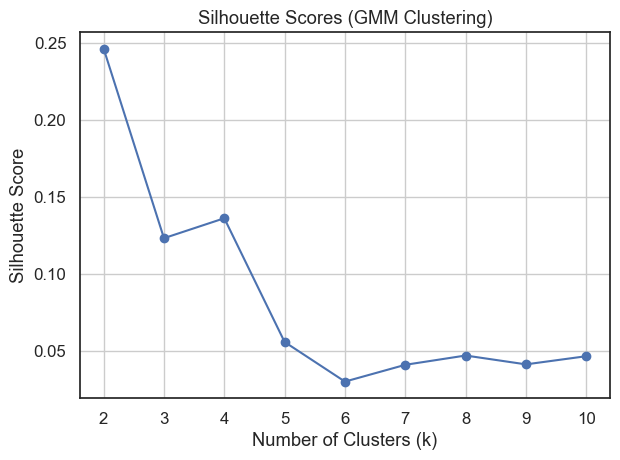

In [294]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare your feature data
X = merged_df[transformed_vars].dropna()

# Try different number of components (clusters)
k_range = range(2, 11)
gmm_scores = []

for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42, covariance_type='full')
    labels = gmm.fit_predict(X)
    score = silhouette_score(X, labels)
    gmm_scores.append((k, score))
    print(f"GMM Silhouette Score for k={k}: {score:.3f}")

# Plot silhouette scores
ks, scores = zip(*gmm_scores)
plt.plot(ks, scores, marker='o')
plt.title("Silhouette Scores (GMM Clustering)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()


### Hierarchical Clustering (Agglomerative)

Hierarchical Silhouette Score for k=2: 0.190
Hierarchical Silhouette Score for k=3: 0.152
Hierarchical Silhouette Score for k=4: 0.160
Hierarchical Silhouette Score for k=5: 0.089
Hierarchical Silhouette Score for k=6: 0.092
Hierarchical Silhouette Score for k=7: 0.096
Hierarchical Silhouette Score for k=8: 0.083
Hierarchical Silhouette Score for k=9: 0.084
Hierarchical Silhouette Score for k=10: 0.075


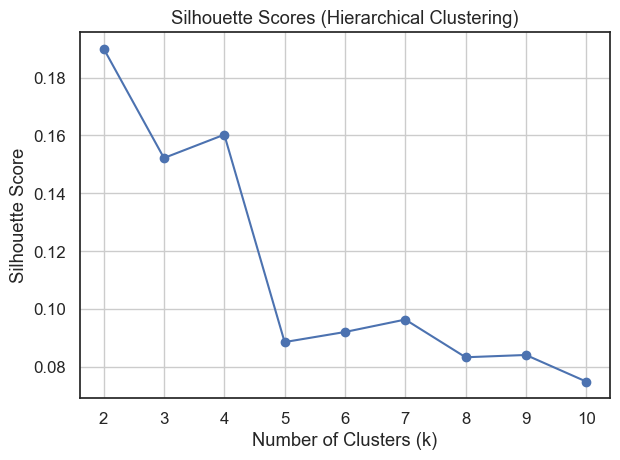

In [295]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Feature matrix
X = merged_df[transformed_vars].dropna()

# Try different cluster numbers
h_scores = []
k_range = range(2, 11)

for k in k_range:
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    h_scores.append((k, score))
    print(f"Hierarchical Silhouette Score for k={k}: {score:.3f}")

# Plot scores
ks, scores = zip(*h_scores)
plt.plot(ks, scores, marker='o')
plt.title("Silhouette Scores (Hierarchical Clustering)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()


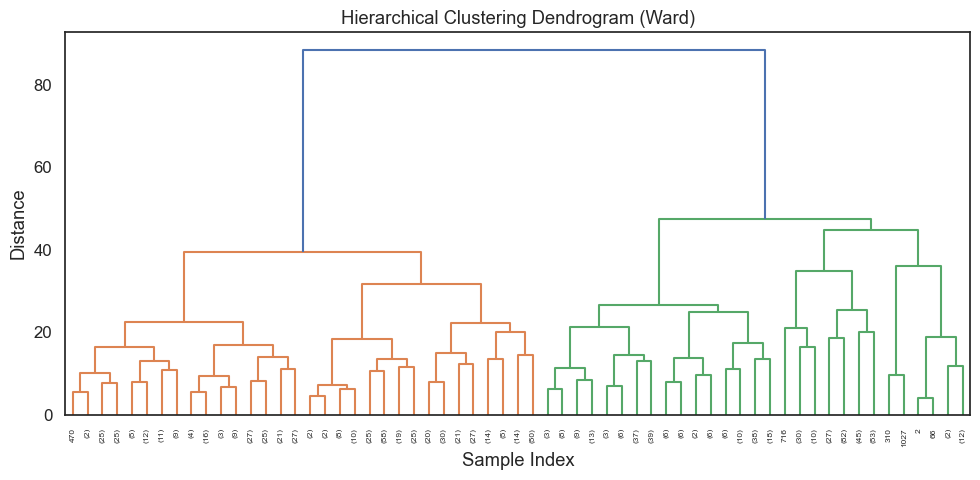

In [296]:
import scipy.cluster.hierarchy as sch

linked = sch.linkage(X, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram (Ward)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


C:\Users\julia\OneDrive - The University of Alabama\Research\202506-ML-EyeTracking\notebooks\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


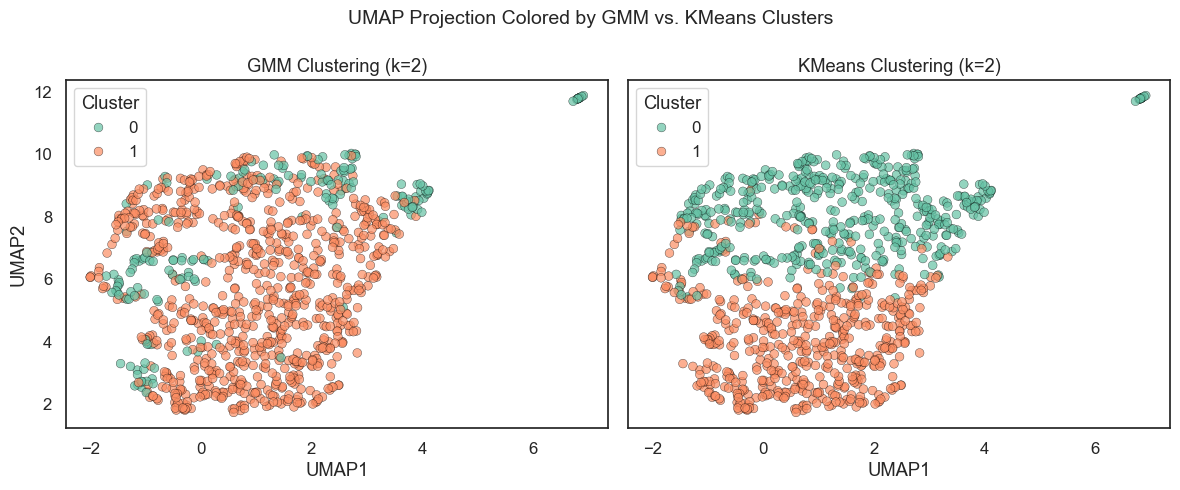

In [297]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap

# Step 1: Prepare features
X = merged_df[transformed_vars].dropna()
X_index = X.index  # keep index to map back

# Step 2: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Fit GMM and KMeans
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Step 4: UMAP Embedding
umap_model = umap.UMAP(n_components=2, random_state=42)
embedding = umap_model.fit_transform(X_scaled)

# Step 5: Combine into a DataFrame
plot_df = pd.DataFrame({
    'UMAP1': embedding[:, 0],
    'UMAP2': embedding[:, 1],
    'GMM_Cluster': gmm_labels,
    'KMeans_Cluster': kmeans_labels
}, index=X_index)

# Optional: merge back other metadata
# plot_df = plot_df.join(merged_df[['theta', 'difficulty_group', ...]])

# Step 6: Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

sns.scatterplot(
    data=plot_df,
    x='UMAP1', y='UMAP2',
    hue='GMM_Cluster',
    palette='Set2',
    s=40, alpha=0.7,
    edgecolor='black',
    linewidth=0.3,
    ax=axes[0]
)
axes[0].set_title('GMM Clustering (k=2)')
axes[0].legend(title='Cluster')

sns.scatterplot(
    data=plot_df,
    x='UMAP1', y='UMAP2',
    hue='KMeans_Cluster',
    palette='Set2',
    s=40, alpha=0.7,
    edgecolor='black',
    linewidth=0.3,
    ax=axes[1]
)
axes[1].set_title('KMeans Clustering (k=2)')
axes[1].legend(title='Cluster')

plt.suptitle("UMAP Projection Colored by GMM vs. KMeans Clusters", fontsize=14)
plt.tight_layout()
plt.show()


In [298]:
# Step 1: Define group labels
# def ability_group(theta):
#     if theta < -0.5:
# #    if theta < 0:
#         return 'low'
#     elif theta > 0.5:
# #    elif theta >= 0:
#         return 'high'
#     else:
#         return 'mid'

def difficulty_group(b):
#    if b < -0.5:
    if b < -0.5:
        return 'easy'
#    elif b > 0.5:
    elif b >= -0.5:
        return 'hard'
    else:
        return 'moderate'

# Apply grouping
#merged_df['ability_group'] = merged_df['theta'].apply(ability_group)


merged_df['difficulty_group'] = merged_df['b'].apply(difficulty_group)

In [299]:
plot_df['difficulty_group'].unique()

KeyError: 'difficulty_group'

### Updated Code: UMAP + Colorblind Palette + Accuracy as Size

C:\Users\julia\OneDrive - The University of Alabama\Research\202506-ML-EyeTracking\notebooks\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


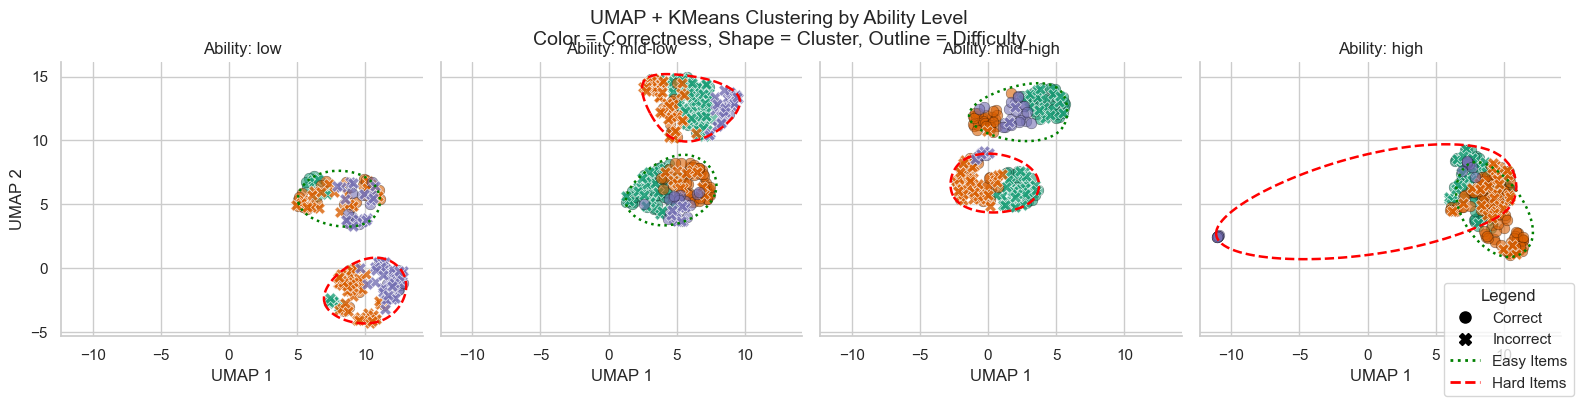

In [319]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.interpolate import splprep, splev
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
import umap

# --- UMAP + KMeans Setup ---
features = transformed_vars  # your feature list
plot_df = merged_df.copy()

plot_df[['UMAP1', 'UMAP2']] = np.nan
plot_df['Cluster'] = np.nan

umap_model = umap.UMAP(n_components=2, random_state=42)

for ability in ['low', 'mid-low', 'mid-high', 'high']:
    for difficulty in ['easy', 'hard']:
        mask = (plot_df['theta_group_kmeans'] == ability) & (plot_df['difficulty_group'] == difficulty)
        subset = plot_df.loc[mask, features].dropna()
        if len(subset) < 5:
            continue
        embedding = umap_model.fit_transform(subset)
        kmeans = KMeans(n_clusters=3, random_state=42).fit(subset)
        labels = kmeans.labels_
        valid_idx = plot_df.loc[mask].dropna(subset=features).index
        plot_df.loc[valid_idx, 'UMAP1'] = embedding[:, 0]
        plot_df.loc[valid_idx, 'UMAP2'] = embedding[:, 1]
        plot_df.loc[valid_idx, 'Cluster'] = labels

# --- Preprocess for plotting ---
plot_df = plot_df.dropna(subset=['UMAP1', 'UMAP2', 'Cluster']).copy()
plot_df['Cluster'] = plot_df['Cluster'].astype(int)
plot_df['response'] = plot_df['response'].astype(bool)  # ensure bool for hue

# Jitter UMAP for outline smoothing
def jitter(series, strength=0.3):
    return series + np.random.normal(0, strength, size=len(series))
plot_df['UMAP1_jitter'] = jitter(plot_df['UMAP1'])
plot_df['UMAP2_jitter'] = jitter(plot_df['UMAP2'])

# Categorical ordering
plot_df['ability_group'] = pd.Categorical(
    plot_df['theta_group_kmeans'], categories=['low', 'mid-low', 'mid-high', 'high'], ordered=True
)
plot_df['difficulty_group'] = pd.Categorical(
    plot_df['difficulty_group'], categories=['easy', 'hard'], ordered=True
)

# --- Plotting with hue = response correctness ---
sns.set(style="whitegrid")
# g = sns.FacetGrid(
#     plot_df,
#     col="ability_group",
#     height=4,
#     aspect=1.1,
#     legend_out=True
# )

# Define a classic, high-contrast palette (6-category)
palette = [
    "#1b9e77",  # Teal
    "#d95f02",  # Orange
    "#7570b3",  # Purple
    "#e7298a",  # Pink
    "#66a61e",  # Olive Green
    "#e6ab02",  # Mustard Yellow
]

# Set the color palette globally
sns.set_palette(palette)

# Create FacetGrid by ability group
g = sns.FacetGrid(
    plot_df,
    col="ability_group",
    hue="Cluster",            # Ensure Cluster is categorical
    height=4,
    aspect=1,
    legend_out=True,
    palette=palette           # Apply palette directly here
)

# Map UMAP scatterplot to each facet
# g.map_dataframe(
#     sns.scatterplot,
#     x="UMAP1",
#     y="UMAP2",
#     alpha=0.6,
#     s=50,
#     edgecolor="black",
#     linewidth=0.2,
#     legend=False             # Avoid duplicate legends
# )

def plot_with_response_shape(data, color, **kwargs):
    # Correct responses: circles
    sns.scatterplot(
        data=data[data['response']],
        x="UMAP1",
        y="UMAP2",
        marker='o',
        color=color,
        s=60,
        edgecolor="black",
        linewidth=0.3,
        alpha=0.6,
        **kwargs
    )
    # Incorrect responses: X
    sns.scatterplot(
        data=data[~data['response']],
        x="UMAP1",
        y="UMAP2",
        marker='X',
        color=color,
        s=70,
        edgecolor="white",
        linewidth=0.5,
        alpha=0.8,
        **kwargs
    )

g.map_dataframe(plot_with_response_shape)




# --- Convex Hulls with Spline Smoothing ---
for ax, ability in zip(g.axes.flat, g.col_names):
    for difficulty, color, linestyle in zip(['easy', 'hard'], ['green', 'red'], ['dotted', 'dashed']):
        sub = plot_df[(plot_df['ability_group'] == ability) & (plot_df['difficulty_group'] == difficulty)]
        if len(sub) < 4:
            continue
        points = sub[['UMAP1_jitter', 'UMAP2_jitter']].dropna().values
        try:
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]
            hull_points = np.vstack([hull_points, hull_points[0]])  # close loop
            tck, _ = splprep([hull_points[:, 0], hull_points[:, 1]], s=0.5, per=True)
            smoothed = splev(np.linspace(0, 1, 100), tck)
            ax.plot(smoothed[0], smoothed[1], color=color, linestyle=linestyle, linewidth=1.8)
        except Exception as e:
            print(f"Skipping outline for {ability}-{difficulty}: {e}")

# --- Custom Legends ---
correctness_legend = [
    Line2D([0], [0], marker='o', color='black', label='Correct', markerfacecolor='black', markersize=8, linestyle='None'),
    Line2D([0], [0], marker='X', color='black', label='Incorrect', markerfacecolor='black', markersize=8, linestyle='None'),
]


difficulty_legend = [
    Line2D([0], [0], color='green', linestyle='dotted', lw=2, label='Easy Items'),
    Line2D([0], [0], color='red', linestyle='dashed', lw=2, label='Hard Items')
]

g.fig.legend(handles=correctness_legend + difficulty_legend, loc='lower right', title="Legend")


# --- Final Polish ---
g.set_titles(col_template="Ability: {col_name}")
g.set_axis_labels("UMAP 1", "UMAP 2")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle(
    "UMAP + KMeans Clustering by Ability Level\nColor = Correctness, Shape = Cluster, Outline = Difficulty",
    fontsize=14
)

plt.show()


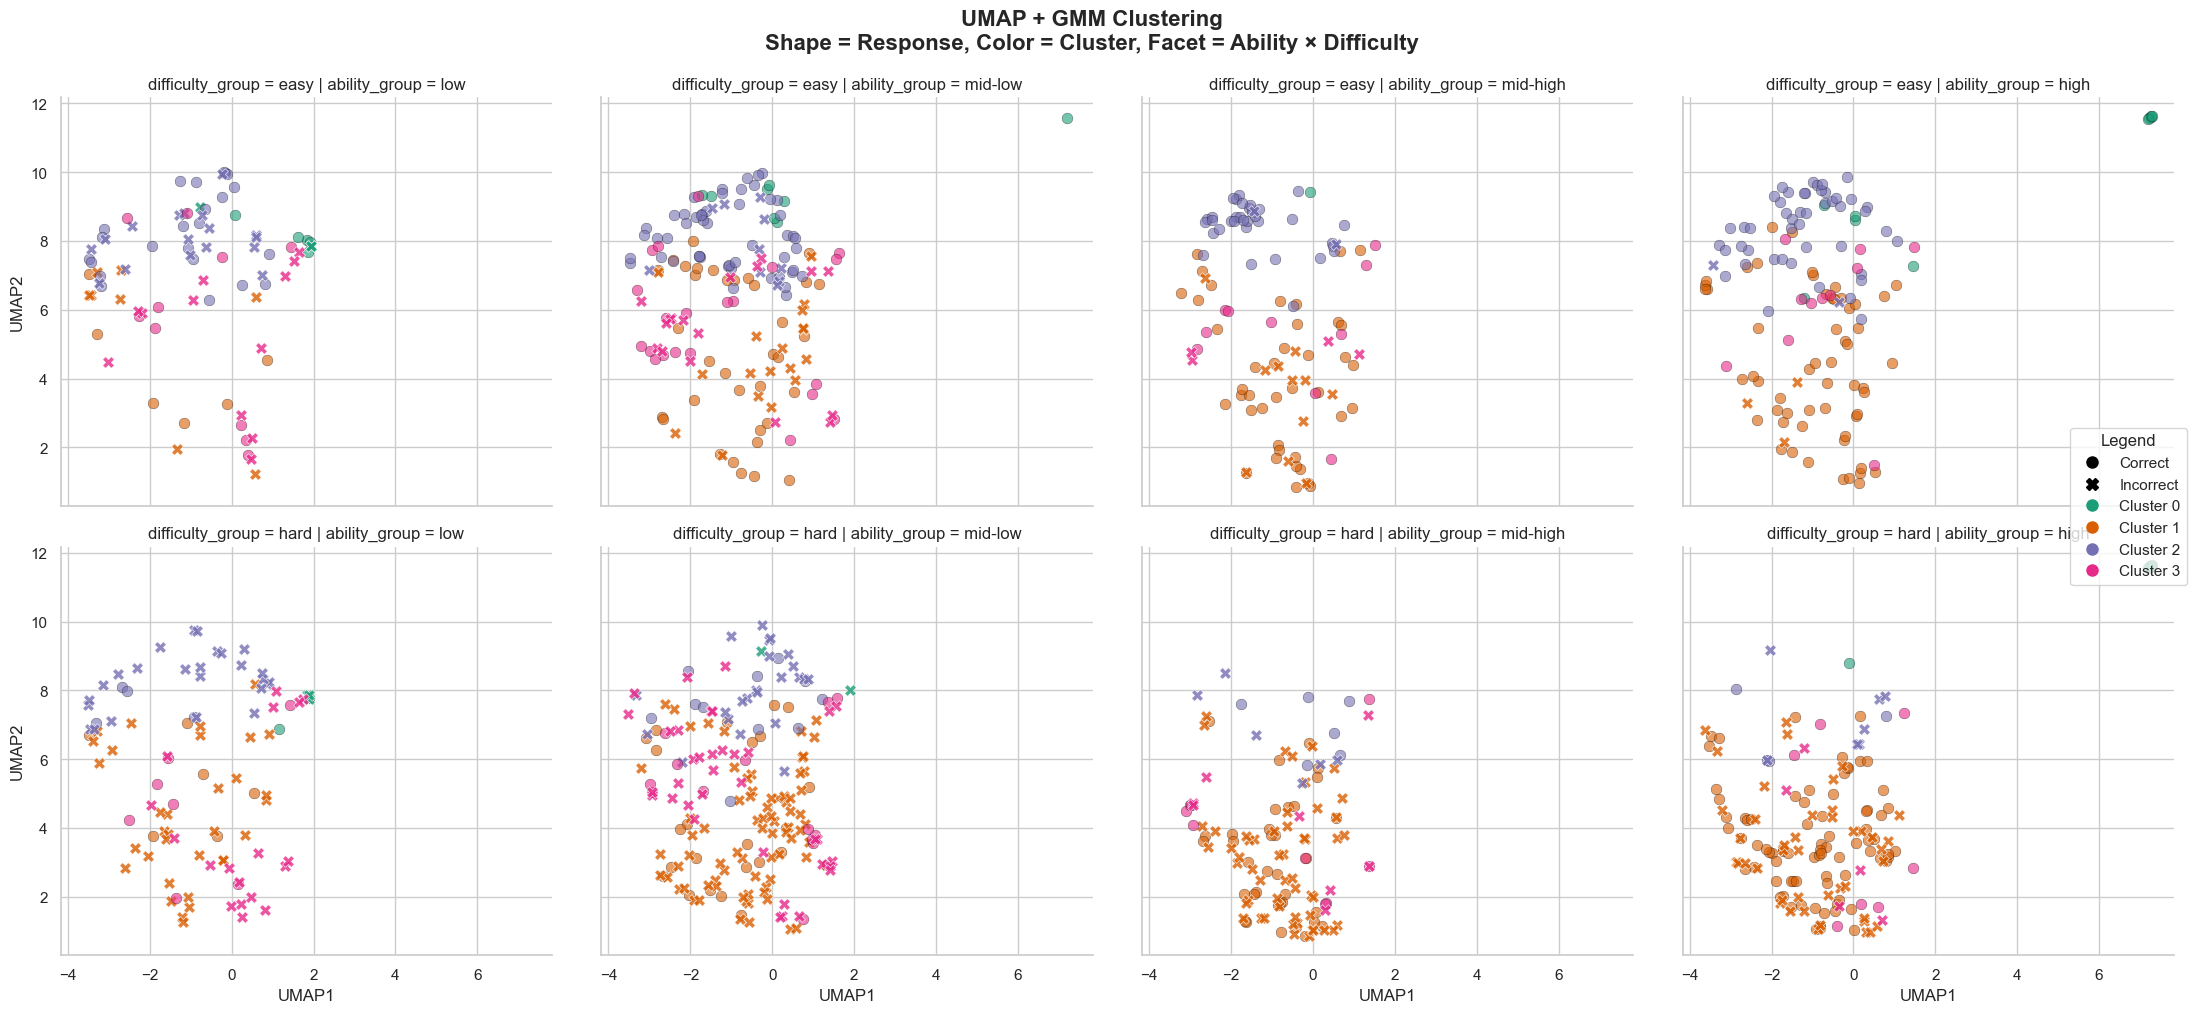

In [352]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.interpolate import splprep, splev
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
import umap
from sklearn.mixture import GaussianMixture



plot_df['UMAP1'] = np.nan
plot_df['UMAP2'] = np.nan
plot_df.loc[umap_input.index, 'UMAP1'] = umap_embedding[:, 0]
plot_df.loc[umap_input.index, 'UMAP2'] = umap_embedding[:, 1]


# ========== GMM Clustering (Global) ==========
plot_df['Cluster'] = np.nan

gmm_input = plot_df.dropna(subset=features).copy()
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(gmm_input[features])
plot_df['Cluster'] = np.nan
plot_df.loc[gmm_input.index, 'Cluster'] = gmm_labels


plot_df = plot_df.dropna(subset=['UMAP1', 'UMAP2', 'Cluster']).copy()
plot_df['Cluster'] = plot_df['Cluster'].astype(int)
plot_df['response'] = plot_df['response'].astype(bool)


def jitter(series, strength=0.3):
    return series + np.random.normal(0, strength, size=len(series))

plot_df['UMAP1_jitter'] = jitter(plot_df['UMAP1'])
plot_df['UMAP2_jitter'] = jitter(plot_df['UMAP2'])

plot_df['ability_group'] = pd.Categorical(
    plot_df['theta_group_kmeans'], categories=['low', 'mid-low', 'mid-high', 'high'], ordered=True)
plot_df['difficulty_group'] = pd.Categorical(
    plot_df['difficulty_group'], categories=['easy', 'hard'], ordered=True)



# ========== Plotting ==========
sns.set(style="whitegrid")
palette = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02"]
sns.set_palette(palette)

g = sns.FacetGrid(
    plot_df,
    row="difficulty_group",
    col="ability_group",
    hue="Cluster",
    height=5.5,
    aspect=1,
    legend_out=True,
    palette=palette
)

def plot_with_response_shape(data, color, **kwargs):
    sns.scatterplot(
        data=data[data['response']],
        x="UMAP1", y="UMAP2", marker='o', color=color,
        s=60, edgecolor="black", linewidth=0.3, alpha=0.6, **kwargs
    )
    sns.scatterplot(
        data=data[~data['response']],
        x="UMAP1", y="UMAP2", marker='X', color=color,
        s=70, edgecolor="white", linewidth=0.5, alpha=0.8, **kwargs
    )

g.map_dataframe(plot_with_response_shape)



# ========== Custom Legend ==========
# ========== Custom Legend ==========

# Existing correctness + difficulty legends
correctness_legend = [
    Line2D([0], [0], marker='o', color='black', label='Correct', markerfacecolor='black', markersize=8, linestyle='None'),
    Line2D([0], [0], marker='X', color='black', label='Incorrect', markerfacecolor='black', markersize=8, linestyle='None'),
]

# 🎨 Cluster color legend based on seaborn palette
cluster_labels = sorted(plot_df['Cluster'].unique())
palette_dict = dict(zip(cluster_labels, sns.color_palette(palette, n_colors=len(cluster_labels))))
cluster_legend = [
    Line2D([0], [0], marker='o', color=color, label=f"Cluster {label}", markerfacecolor=color, markersize=8, linestyle='None')
    for label, color in palette_dict.items()
]

# Combine all legends
all_legends = correctness_legend + cluster_legend

# Plot legend below the plot
g.fig.legend(handles=all_legends, loc='right', ncol=1, title="Legend")

g.fig.suptitle(
    "UMAP + GMM Clustering\nShape = Response, Color = Cluster, Facet = Ability × Difficulty",
    fontsize=16,
    fontweight="bold"
)
g.fig.subplots_adjust(top=0.90, bottom=0.12, hspace=0.1, wspace=0.1)



plt.show()




#### This is a ML with ALL eye tracking metrics

To investigate potential behavioral subgroups within distinct cognitive demand conditions, we applied t-distributed Stochastic Neighbor Embedding (t-SNE) combined with KMeans clustering to participants' eye-tracking features across nine ability–difficulty groups. Participants were first grouped into three ability levels (low, mid, high) based on their IRT-estimated θ scores, and three item difficulty levels (easy, moderate, hard) based on estimated item difficulties (b).

For dimensionality reduction, t-SNE was applied using the top 10 principal components derived from the original eye-tracking metrics. To balance local and global structure, we tested multiple perplexity values (20, 25, 50) and selected perplexity = 25 as the optimal setting. This value yielded the most interpretable embeddings with clear and compact cluster formations while preserving a meaningful global layout (see Figure X).

KMeans clustering (K = 3) was then performed within each of the 3×3 ability–difficulty subgroups on the t-SNE-reduced data. The resulting clusters were visualized using a FacetGrid, with each panel representing one ability × difficulty condition (Figure X). Visual inspection reveals distinct clustering patterns:

In easy conditions, participants exhibited more dispersed gaze behavior, often forming three visibly separable clusters.

In moderate conditions, clusters were tighter and more symmetrical, suggesting more consistent strategy use.

In hard conditions, the cluster structures varied more across ability levels. For example, hard | high produced two primary strategy clusters, while hard | low revealed greater heterogeneity.

These clusters may reflect different cognitive strategies (e.g., impulsive scanning vs. systematic comparison). To further interpret them, we calculated cluster-wise accuracy and averaged eye-tracking features across clusters. Several clusters exhibited notably higher accuracy and lower fixation counts, possibly indicating more efficient or goal-directed processing.

This analysis demonstrates the feasibility of combining dimensionality reduction and unsupervised learning to uncover latent strategy profiles in eye-tracking data. It also highlights how the interaction between item difficulty and participant ability influences the emergence of distinct response patterns.

In [354]:
# Make sure Cluster is int
plot_df['Cluster'] = plot_df['Cluster'].astype('Int64')

# Select only rows with all necessary values
cluster_data = plot_df.dropna(subset=transformed_vars + ['Cluster'])

# Group by cluster and compute means
cluster_profile = cluster_data.groupby('Cluster')[transformed_vars].mean().round(2)

# Optional: add sample size per cluster
cluster_profile['N'] = cluster_data['Cluster'].value_counts().sort_index()

# View the profile table
import pandas as pd
pd.set_option("display.max_columns", 100)  # show all columns
display(cluster_profile)


AVERAGE_FIXATION_DURATION_log  FIXATION_COUNT_log  \
Cluster                                                      
0                                -0.04               -2.42   
1                                 0.38                0.59   
2                                -0.24               -0.78   
3                                -0.37                0.10   

         FIXATION_DURATION_MAX_log  FIXATION_DURATION_MIN_log  \
Cluster                                                         
0                            -0.48                       0.39   
1                             0.50                      -0.02   
2                            -0.68                       0.34   
3                            -0.04                      -0.36   

         MEDIAN_FIXATION_DURATION_log  SD_FIXATION_DURATION_log  \
Cluster                                                           
0                               -0.00                     -0.81   
1                                0.31                      0.34   
2                               -0.03                     -0.40   
3                               -0.52                      0.03   

         AVERAGE_SACCADE_AMPLITUDE_sqrt  MEDIAN_SACCADE_AMPLITUDE_sqrt  \
Cluster                                                                  
0                                 -0.60                          -0.74   
1                                 -0.14                          -0.24   
2                                  0.14                           0.53   
3                                  0.35                          -0.00   

         SACCADE_COUNT_log  SD_SACCADE_AMPLITUDE  PUPIL_SIZE_MEAN  \
Cluster                                                             
0                    -2.23                 -1.54            -0.40   
1                     0.61                 -0.02             0.04   
2                    -0.84                 -0.24            -0.16   
3                     0.10                  0.87             0.20   

         PUPIL_SIZE_MAX_log  PUPIL_SIZE_MIN  AVERAGE_BLINK_DURATION_log  \
Cluster                                                                   
0                     -0.20           -0.37                        2.27   
1                     -0.05           -0.07                       -0.29   
2                     -0.45            0.44                       -0.22   
3                      0.85           -0.32                        0.63   

         BLINK_COUNT_log  RUN_COUNT_log  \
Cluster                                   
0                  -0.16          -2.80   
1                   0.29           0.59   
2                  -0.84          -0.57   
3                   0.53          -0.16   

         VISITED_INTEREST_AREA_COUNT_reflectlog  DURATION_log  \
Cluster                                                         
0                                          2.19         -0.76   
1                                         -0.50          0.64   
2                                          0.41         -1.04   
3                                          0.23          0.09   

         IP_DURATION_log    N  
Cluster                        
0                  -0.77   42  
1                   0.64  526  
2                  -1.04  271  
3                   0.09  189

In [411]:
spaced_df

Cluster                                  0         1         2         3
Group Metric                                                            
1     Duration                   -0.736782  1.356336 -1.154046  0.534493
      IP_Duration                -0.738338  1.354849 -1.153595  0.537084
NaN                                    NaN       NaN       NaN       NaN
2     FIXATION_Count             -1.562918  1.067663 -0.136264  0.631519
      FIXATION_Duration(max)     -0.677716  1.491187 -1.108944  0.295473
      FIXATION_Duration(Average)  0.097868  1.574456 -0.598281 -1.074043
      FIXATION_Duration(Median)   0.191662  1.256839  0.092617 -1.541118
      FIXATION_Duration(min)      0.996724 -0.364976  0.840366 -1.472114
      FIXATION_Duration(sd)      -1.384061  1.259125 -0.433100  0.558035
NaN                                    NaN       NaN       NaN       NaN
3     SACCADE_Count              -1.517072  1.110352 -0.234190  0.640910
      SACCADE_Amplitude(Average) -1.505953 -0.229188  0.572424  1.162717
      SACCADE_Amplitude(Median)  -1.378384 -0.267792  1.403345  0.242831
      SACCADE_Amplitude(sd)      -1.517211  0.248738 -0.010623  1.279096
NaN                                    NaN       NaN       NaN       NaN
4     PUPIL_Size(Mean)           -1.431147  0.527385 -0.343509  1.247271
      PUPIL_SIZE(max)            -0.474572 -0.185231 -0.997276  1.657079
      PUPIL_SIZE(min)            -0.901277  0.016006  1.624920 -0.739648
NaN                                    NaN       NaN       NaN       NaN
5     BLINK_Count                -0.211311  0.639450 -1.528375  1.100237
      BLINK_Duration(Average)     1.622360 -0.861542 -0.790453  0.029634
NaN                                    NaN       NaN       NaN       NaN
6     RUN_Count                  -1.634884  1.050300  0.129266  0.455318
      AOI_Count                   1.626135 -1.093894 -0.172742 -0.359499

In [416]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# === Step 1: Setup rename and group info ===
rename_dict = {
    'FIXATION_COUNT_log': 'FIXATION_Count',
    'FIXATION_DURATION_MAX_log': 'FIXATION_Duration(max)',
    'AVERAGE_FIXATION_DURATION_log': 'FIXATION_Duration(Average)',
    'MEDIAN_FIXATION_DURATION_log': 'FIXATION_Duration(Median)',
    'FIXATION_DURATION_MIN_log': 'FIXATION_Duration(min)',
    'SD_FIXATION_DURATION_log': 'FIXATION_Duration(sd)',
    'SACCADE_COUNT_log': 'SACCADE_Count',
    'AVERAGE_SACCADE_AMPLITUDE_sqrt': 'SACCADE_Amplitude(Average)',
    'MEDIAN_SACCADE_AMPLITUDE_sqrt': 'SACCADE_Amplitude(Median)',
    'SD_SACCADE_AMPLITUDE': 'SACCADE_Amplitude(sd)',
    'PUPIL_SIZE_MEAN': 'PUPIL_Size(Mean)',
    'PUPIL_SIZE_MAX_log': 'PUPIL_SIZE(max)',
    'PUPIL_SIZE_MIN': 'PUPIL_SIZE(min)',
    'BLINK_COUNT_log': 'BLINK_Count',
    'AVERAGE_BLINK_DURATION_log': 'BLINK_Duration(Average)',
    'RUN_COUNT_log': 'RUN_Count',
    'VISITED_INTEREST_AREA_COUNT_reflectlog': 'AOI_Count',
    'DURATION_log': 'Duration',
    'IP_DURATION_log': 'IP_Duration'
}

# Define metric groups (already renamed)
categories = {
    '1': [
        'Duration',
        'IP_Duration'
    ],
    '2': [
        'FIXATION_Count',
        'FIXATION_Duration(max)',
        'FIXATION_Duration(Average)',
        'FIXATION_Duration(Median)',
        'FIXATION_Duration(min)',
        'FIXATION_Duration(sd)'
    ],
    '3': [
        'SACCADE_Count',
        'SACCADE_Amplitude(Average)',
        'SACCADE_Amplitude(Median)',
        'SACCADE_Amplitude(sd)'
    ],
    '4': [
        'PUPIL_Size(Mean)',
        'PUPIL_SIZE(max)',
        'PUPIL_SIZE(min)'
    ],
    '5': [
        'BLINK_Count',
        'BLINK_Duration(Average)'
    ],
    '6': [
        'RUN_Count',
        'AOI_Count'
    ]

}
# === Step 2: Compute standardized profile ===
ordered_metrics = [k for group in categories.values() for k in group]
reverse_rename = {v: k for k, v in rename_dict.items()}
raw_metric_names = [reverse_rename[m] for m in ordered_metrics]

cluster_profile = cluster_data.groupby('Cluster')[raw_metric_names].mean()
scaler = StandardScaler()
cluster_profile_std = pd.DataFrame(
    scaler.fit_transform(cluster_profile),
    columns=raw_metric_names,
    index=cluster_profile.index
)
cluster_profile_std = cluster_profile_std.rename(columns=rename_dict)
cluster_profile_std = cluster_profile_std[ordered_metrics].T  # Metrics as rows

# === Step 3: Insert blank rows between categories ===
spaced_rows = []
for group_name, metric_list in categories.items():
    for m in metric_list:
        row = cluster_profile_std.loc[m]
        spaced_rows.append((group_name, m, row))
    # Insert a blank row (NaNs)
    spaced_rows.append((None, '', pd.Series([np.nan]*cluster_profile_std.shape[1], index=cluster_profile_std.columns)))

# Remove the last blank row
spaced_rows = spaced_rows[:-1]

# Create new DataFrame with MultiIndex
group_labels, metric_labels, rows = zip(*spaced_rows)
spaced_df = pd.DataFrame(rows, index=pd.MultiIndex.from_tuples(zip(group_labels, metric_labels), names=['Group', 'Metric']))

# Sort clusters (columns) by their Duration values
# Sort clusters (columns) by Duration metric (ascending)
duration_values = spaced_df.loc[('1', 'Duration')]
sorted_clusters = duration_values.sort_values().index
spaced_df = spaced_df[sorted_clusters]





# === Step 4: Plot ===


plt.figure(figsize=(8, 7))
sns.set(style="white")

ax = sns.heatmap(
    spaced_df,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.4,
    linecolor="white",
    annot_kws={"size": 8},
    cbar_kws={'label': 'Z-score'}
)

plt.title("Standardized Eye-Tracking Profiles by Cluster", fontsize=12, pad=12)
plt.xlabel("Cluster", fontsize=10)
plt.ylabel("Metric", fontsize=10)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()


C:\Users\julia\AppData\Local\Temp\ipykernel_19428\2452522261.py:98: PerformanceWarning: indexing past lexsort depth may impact performance.
  duration_values = spaced_df.loc[('1', 'Duration')]


TypeError: DataFrame.sort_values() missing 1 required positional argument: 'by'

In [417]:
spaced_df

Cluster                                  0         1         2         3
Group Metric                                                            
1     Duration                   -0.736782  1.356336 -1.154046  0.534493
      IP_Duration                -0.738338  1.354849 -1.153595  0.537084
NaN                                    NaN       NaN       NaN       NaN
2     FIXATION_Count             -1.562918  1.067663 -0.136264  0.631519
      FIXATION_Duration(max)     -0.677716  1.491187 -1.108944  0.295473
      FIXATION_Duration(Average)  0.097868  1.574456 -0.598281 -1.074043
      FIXATION_Duration(Median)   0.191662  1.256839  0.092617 -1.541118
      FIXATION_Duration(min)      0.996724 -0.364976  0.840366 -1.472114
      FIXATION_Duration(sd)      -1.384061  1.259125 -0.433100  0.558035
NaN                                    NaN       NaN       NaN       NaN
3     SACCADE_Count              -1.517072  1.110352 -0.234190  0.640910
      SACCADE_Amplitude(Average) -1.505953 -0.229188  0.572424  1.162717
      SACCADE_Amplitude(Median)  -1.378384 -0.267792  1.403345  0.242831
      SACCADE_Amplitude(sd)      -1.517211  0.248738 -0.010623  1.279096
NaN                                    NaN       NaN       NaN       NaN
4     PUPIL_Size(Mean)           -1.431147  0.527385 -0.343509  1.247271
      PUPIL_SIZE(max)            -0.474572 -0.185231 -0.997276  1.657079
      PUPIL_SIZE(min)            -0.901277  0.016006  1.624920 -0.739648
NaN                                    NaN       NaN       NaN       NaN
5     BLINK_Count                -0.211311  0.639450 -1.528375  1.100237
      BLINK_Duration(Average)     1.622360 -0.861542 -0.790453  0.029634
NaN                                    NaN       NaN       NaN       NaN
6     RUN_Count                  -1.634884  1.050300  0.129266  0.455318
      AOI_Count                   1.626135 -1.093894 -0.172742 -0.359499

In [357]:
# Step 2: Calculate accuracy (mean response) across Cluster × Ability × Difficulty
accuracy_summary = (
    cluster_data.dropna(subset=['Cluster', 'response'])
    .groupby(['Cluster', 'ability_group', 'difficulty_group'])['response']
    .agg(Accuracy='mean', Count='count')
    .round(3)
    .reset_index()
)

print(accuracy_summary)


    Cluster ability_group difficulty_group  Accuracy  Count
0         0           low             easy     0.625      8
1         0           low             hard     0.400      5
2         0       mid-low             easy     1.000      8
3         0       mid-low             hard     0.000      2
4         0      mid-high             easy     1.000      1
5         0      mid-high             hard       NaN      0
6         0          high             easy     1.000     10
7         0          high             hard     1.000      8
8         1           low             easy     0.429     14
9         1           low             hard     0.154     39
10        1       mid-low             easy     0.660     53
11        1       mid-low             hard     0.232     99
12        1      mid-high             easy     0.784     51
13        1      mid-high             hard     0.398     88
14        1          high             easy     0.949     59
15        1          high             ha

C:\Users\julia\AppData\Local\Temp\ipykernel_19428\1647414704.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Cluster', 'ability_group', 'difficulty_group'])['response']


In [349]:
cluster_data['ability_group'].unique()

array(['high', 'mid', 'low'], dtype=object)

C:\Users\julia\AppData\Local\Temp\ipykernel_19428\2837514906.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['ability_group', 'difficulty_group', 'Cluster'])


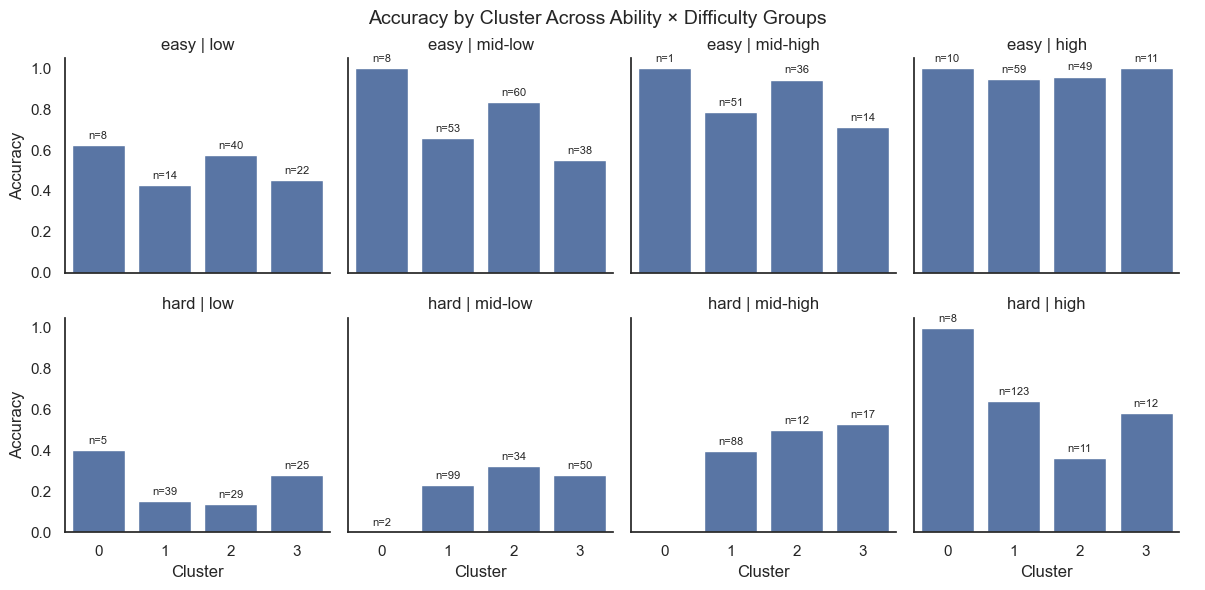

In [360]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Add count (n) if not already included
#if 'n' not in accuracy_summary.columns:
accuracy_summary = (
        cluster_data
        .groupby(['ability_group', 'difficulty_group', 'Cluster'])
        .agg(Accuracy=('response', 'mean'), n=('response', 'count'))
        .reset_index()
)

# Step 2: Set orderings
#ability_order = ['low', 'mid', 'high']
ability_order = ['low', 'mid-low', 'mid-high' , 'high']
difficulty_order = ['easy', 'hard']

# Step 3: Plot
g = sns.catplot(
    data=accuracy_summary,
    x='Cluster', y='Accuracy',
    col='ability_group', col_order=ability_order,
    row='difficulty_group', row_order=difficulty_order,
    kind='bar', height=3, aspect=1
)

g.set_axis_labels("Cluster", "Accuracy")
g.set_titles("{row_name} | {col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Accuracy by Cluster Across Ability × Difficulty Groups", fontsize=14)

# Step 4: Annotate each bar with n
for ax in g.axes.flat:
    for bar in ax.patches:
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2
        cluster_label = int(round(bar.get_x()))

        # Get ability and difficulty from facet titles
        try:
            difficulty, ability = [s.strip() for s in ax.get_title().split('|')]
        except ValueError:
            continue

        # Find match
        match = accuracy_summary[
            (accuracy_summary['Cluster'] == cluster_label) &
            (accuracy_summary['ability_group'] == ability) &
            (accuracy_summary['difficulty_group'] == difficulty)
        ]

        if not match.empty:
            count = int(match['n'].values[0])
            ax.text(x, height + 0.02, f'n={count}', ha='center', va='bottom', fontsize=8)

plt.show()


In [367]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Ensure challenge is computed
cluster_data['challenge'] = cluster_data['b']-cluster_data['theta']

# Remove missing data
anova_df = cluster_data.dropna(subset=['challenge', 'Cluster']).copy()
anova_df['Cluster'] = anova_df['Cluster'].astype('category')

# Fit the model
model = smf.ols('challenge ~ C(Cluster)', data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)


                 sum_sq      df          F        PR(>F)
C(Cluster)   264.496573     3.0  20.735321  4.783173e-13
Residual    4353.995693  1024.0        NaN           NaN


C:\Users\julia\AppData\Local\Temp\ipykernel_19428\744003675.py:5: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=anova_df, x='Cluster', y='challenge', hue='Cluster', dodge=False,


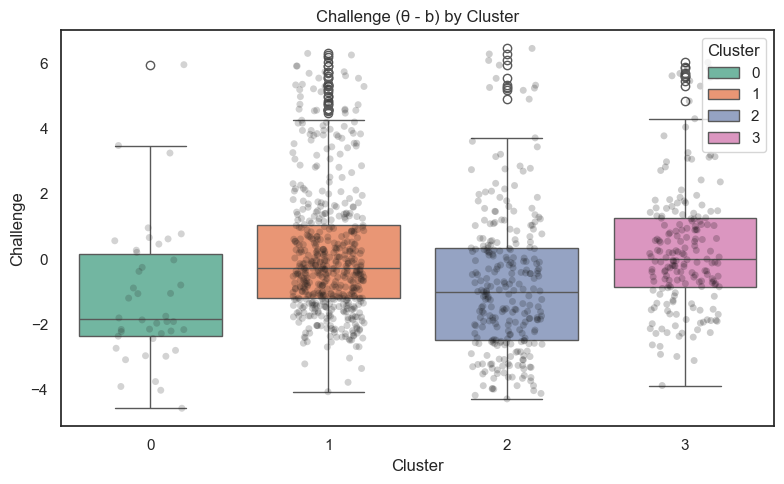

In [368]:
plt.figure(figsize=(8, 5))

# Use Cluster as both x and hue
sns.boxplot(data=anova_df, x='Cluster', y='challenge', hue='Cluster', palette='Set2', dodge=False)
sns.stripplot(data=anova_df, x='Cluster', y='challenge', hue='Cluster', dodge=False,
              color='black', alpha=0.2, jitter=0.2, legend=False)

plt.title("Challenge (θ - b) by Cluster")
plt.ylabel("Challenge")
plt.xlabel("Cluster")
plt.legend(title="Cluster", loc='upper right')
plt.tight_layout()
plt.show()


In [369]:
# One-hot encode cluster
X = pd.get_dummies(anova_df['Cluster'], drop_first=True)
y = anova_df['challenge']

# Fit linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)

# Coefficients
for cluster_name, coef in zip(X.columns, model.coef_):
    print(f"{cluster_name}: {coef:.3f}")

print(f"R^2: {model.score(X, y):.3f}")


1: 1.373
2: 0.369
3: 1.501
R^2: 0.057


C:\Users\julia\AppData\Local\Temp\ipykernel_19428\2054981103.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = response_matrix.applymap(lambda x: "o" if x == 1 else ("x" if x == 0 else ""))
C:\Users\julia\AppData\Local\Temp\ipykernel_19428\2054981103.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric_matrix = cluster_matrix_sorted.applymap(lambda x: cluster_to_int.get(x, np.nan))


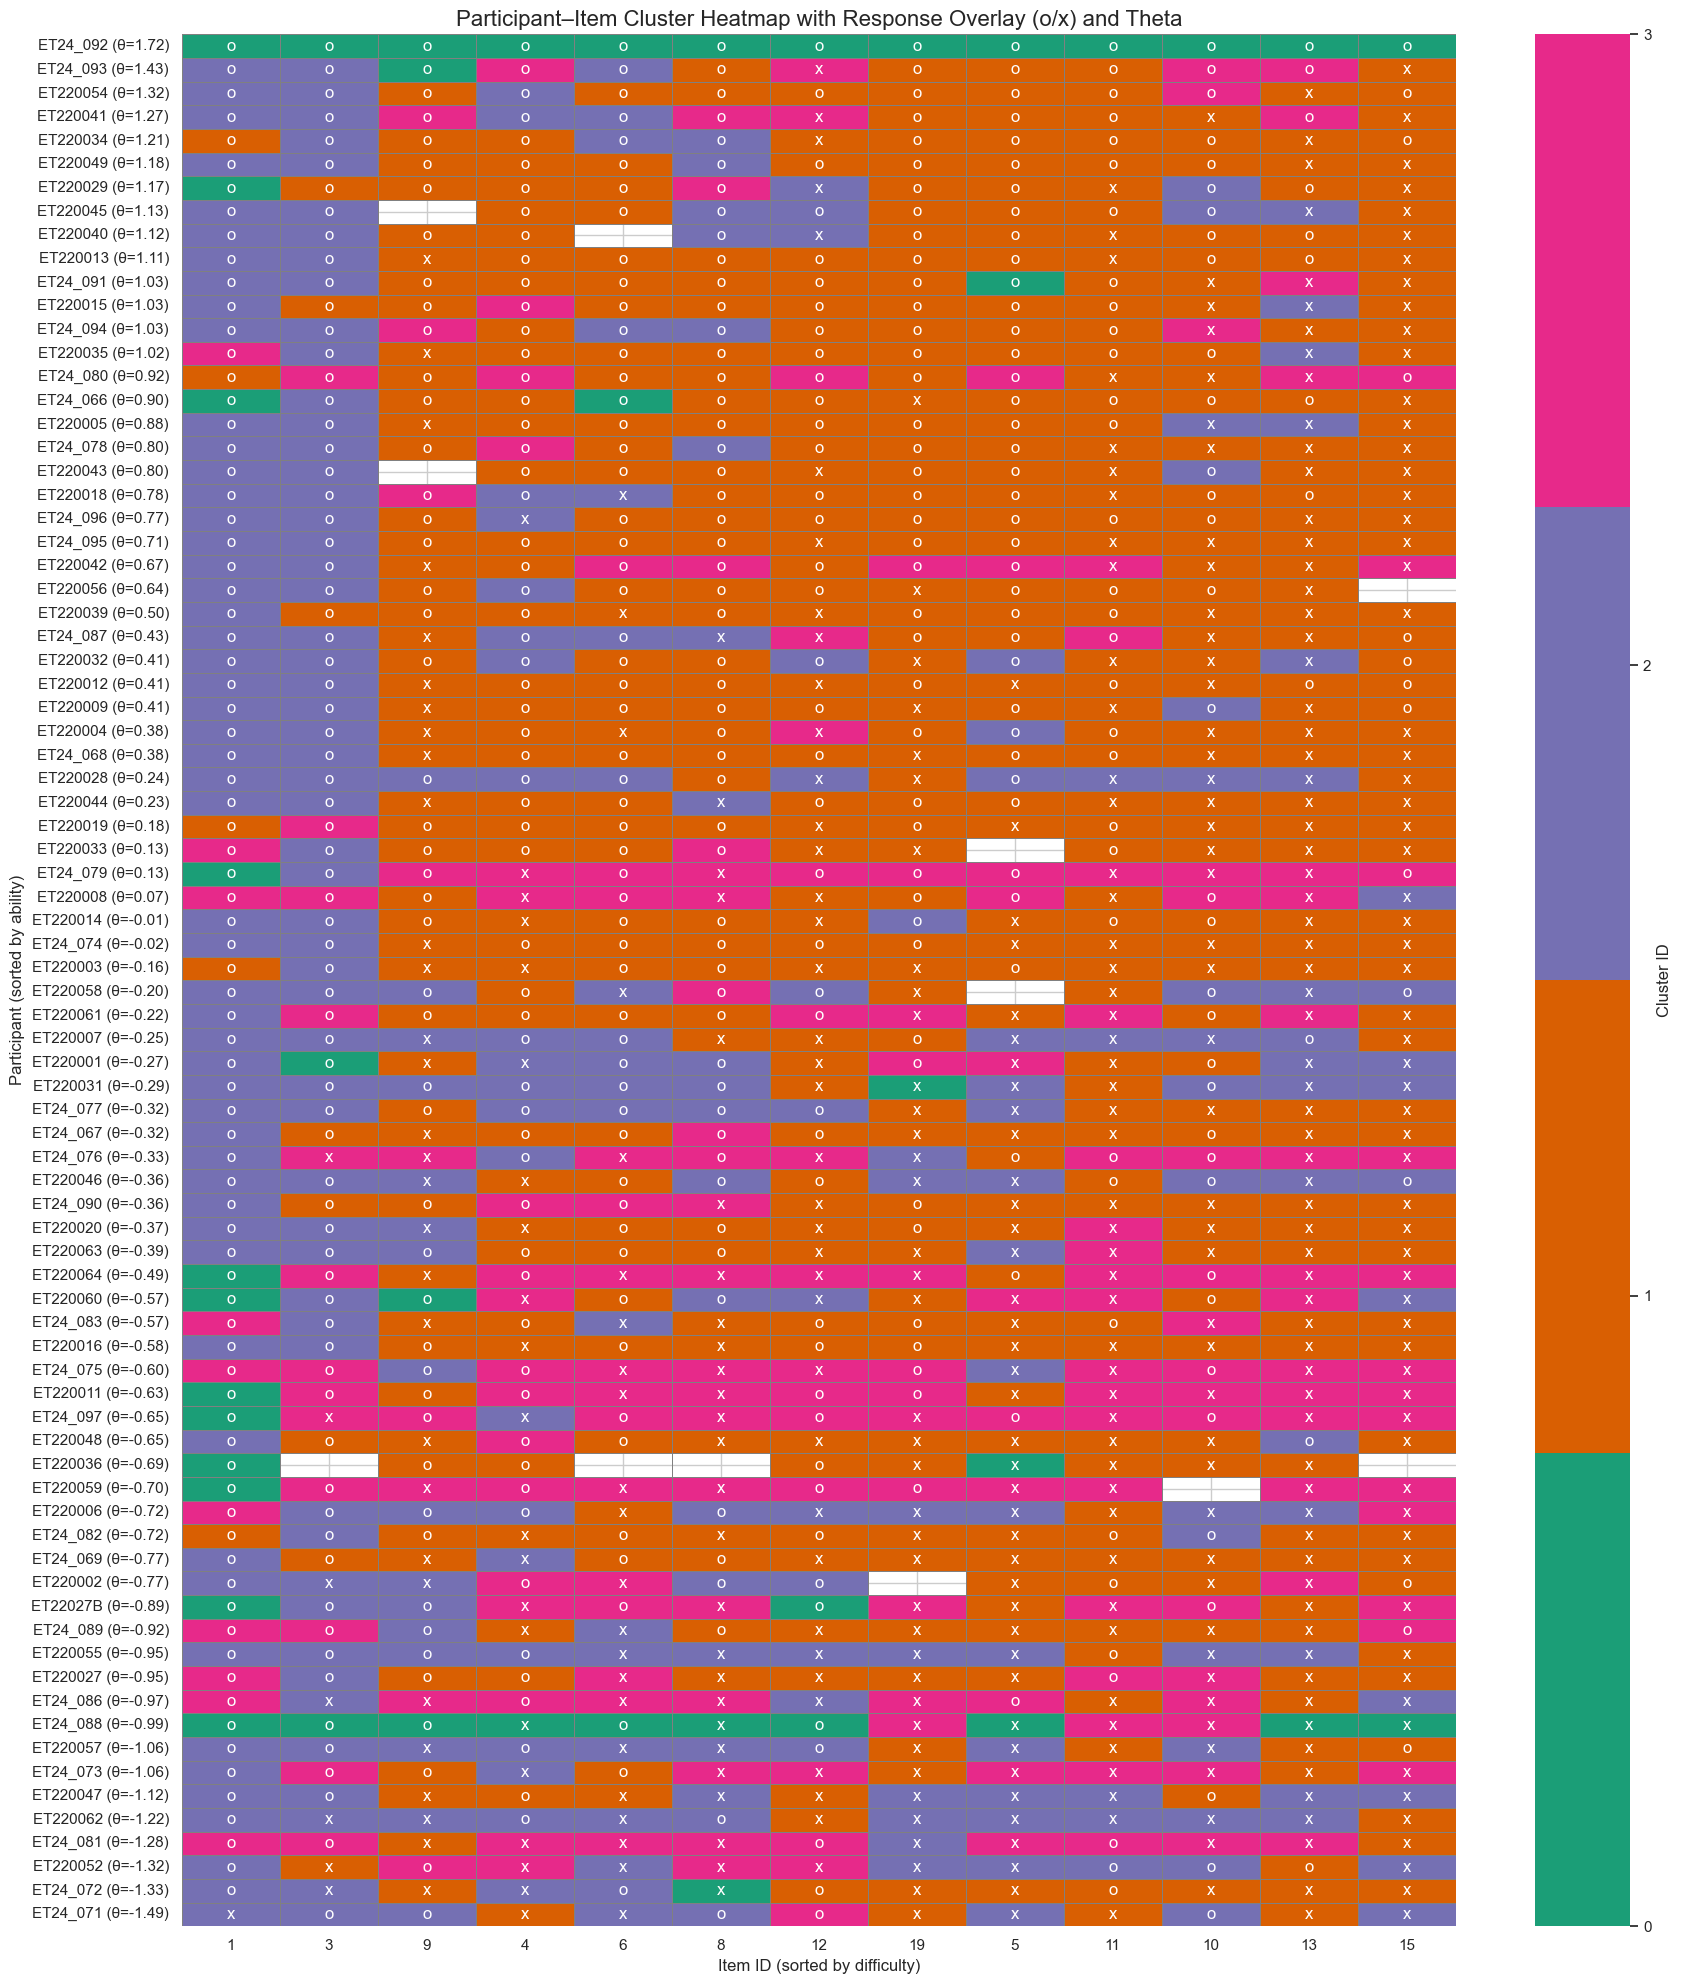

In [406]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ========== Set style and cluster palette ==========
sns.set(style="whitegrid")
cluster_palette = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02"]

# ========== Step 1: Prepare data ==========
heat_df = cluster_data.dropna(subset=['RECORDING_SESSION_LABEL', 'trialid', 'Cluster', 'response'])
heat_df['Cluster'] = heat_df['Cluster'].astype(str)  # categorical cluster

# ========== Step 2: Pivot cluster and response ==========
cluster_matrix = heat_df.pivot(index='RECORDING_SESSION_LABEL', columns='trialid', values='Cluster')
response_matrix = heat_df.pivot(index='RECORDING_SESSION_LABEL', columns='trialid', values='response')
annot_matrix = response_matrix.applymap(lambda x: "o" if x == 1 else ("x" if x == 0 else ""))

# ========== Step 3: Order items by difficulty ==========
item_difficulty = merged_df[['trialid', 'b']].drop_duplicates().set_index('trialid')['b']
sorted_items = item_difficulty.sort_values().index
cluster_matrix = cluster_matrix[sorted_items]
annot_matrix = annot_matrix[sorted_items]

# ========== Step 4: Add theta and sort participants ==========
ability_df = merged_df[['RECORDING_SESSION_LABEL', 'theta']].drop_duplicates().set_index('RECORDING_SESSION_LABEL')
cluster_matrix = cluster_matrix.join(ability_df).sort_values(by='theta', ascending=False)
annot_matrix = annot_matrix.loc[cluster_matrix.index]
theta_sorted = cluster_matrix['theta']
cluster_matrix_sorted = cluster_matrix.drop(columns='theta')

# ========== Step 5: Map cluster to integers for color ==========
unique_clusters = sorted(cluster_matrix_sorted.stack().dropna().unique())
cluster_to_int = {c: i for i, c in enumerate(unique_clusters)}
color_map = {str(k): cluster_palette[i % len(cluster_palette)] for i, k in enumerate(unique_clusters)}
numeric_matrix = cluster_matrix_sorted.applymap(lambda x: cluster_to_int.get(x, np.nan))

# ========== Step 6: Plot ==========
fig, ax = plt.subplots(figsize=(18, min(0.4 * cluster_matrix_sorted.shape[0], 20)))

cmap = sns.color_palette([color_map.get(str(c), "#ffffff") for c in unique_clusters])
sns.heatmap(
    numeric_matrix,
    annot=annot_matrix,
    fmt="",
    cmap=cmap,
    cbar_kws={'ticks': list(range(len(unique_clusters))), 'label': 'Cluster ID'},
    linewidths=0.5,
    linecolor='gray',
    xticklabels=True,
    yticklabels=[f"{idx} (θ={theta_sorted.loc[idx]:.2f})" for idx in numeric_matrix.index]
)

# Adjust colorbar tick labels to match original Cluster labels
colorbar = ax.collections[0].colorbar
colorbar.set_ticks(list(range(len(unique_clusters))))
colorbar.set_ticklabels(unique_clusters)

plt.title("Participant–Item Cluster Heatmap with Response Overlay (o/x) and Theta", fontsize=16)
plt.xlabel("Item ID (sorted by difficulty)")
plt.ylabel("Participant (sorted by ability)")
plt.tight_layout()
plt.show()


#### Count Participants per Cluster per Item

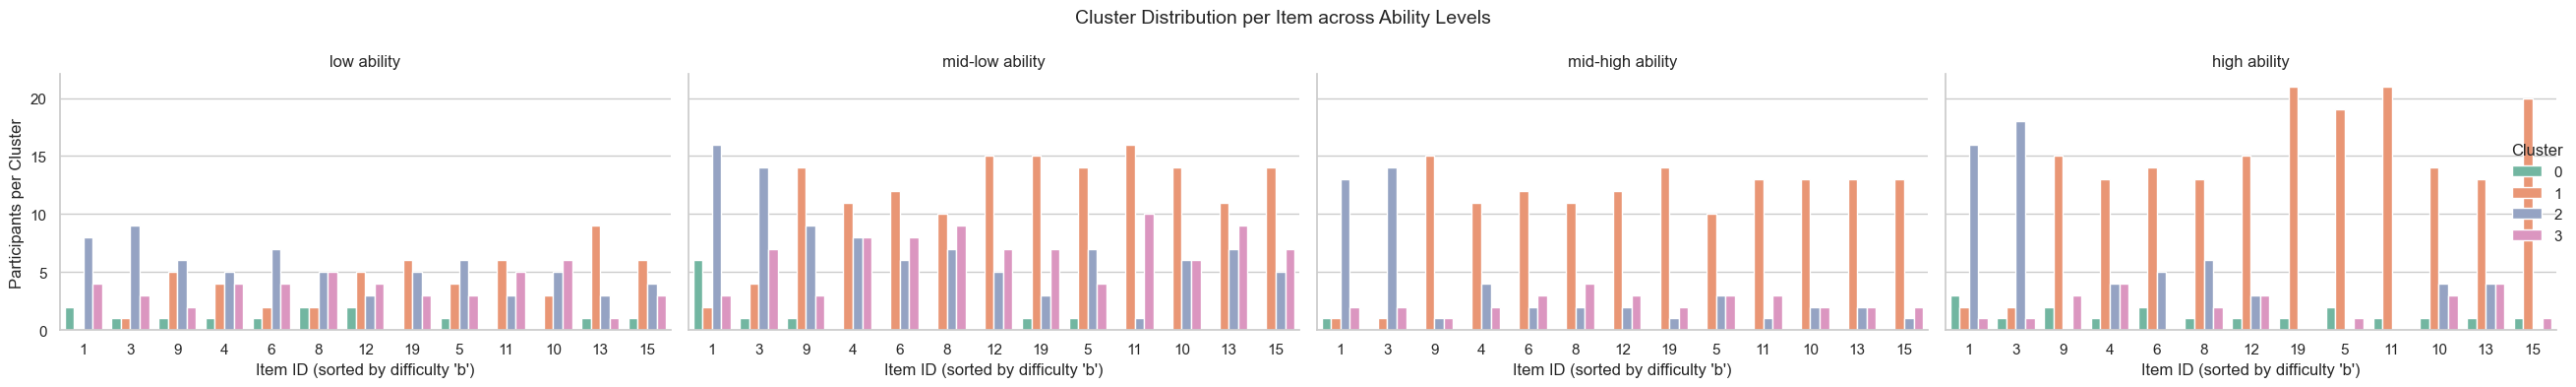

In [378]:
# Step 1: Prepare long-format DataFrame for plotting
records = []

for ability in ['low', 'mid-low', 'mid-high', 'high']:
    subset_df = cluster_data[merged_df['ability_group'] == ability]
    
    # Count per item-cluster
    cluster_counts = (
        subset_df.dropna(subset=['Cluster'])
        .groupby(['trialid', 'Cluster'])
        .size()
        .reset_index(name='count')
    )
    cluster_counts['ability_group'] = ability

    # Merge difficulty info
    difficulty = subset_df[['trialid', 'b']].drop_duplicates()
    cluster_counts = cluster_counts.merge(difficulty, on='trialid', how='left')
    
    records.append(cluster_counts)

# Combine all ability groups
plot_df = pd.concat(records)

# Step 2: Sort trialid by mean difficulty (for consistent x-axis)
trialid_order = plot_df.groupby('trialid')['b'].mean().sort_values().index.tolist()
plot_df['trialid'] = pd.Categorical(plot_df['trialid'], categories=trialid_order, ordered=True)

# Step 3: Plot using catplot
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.catplot(
    data=plot_df, kind="bar",
    x="trialid", y="count", hue="Cluster",
    col="ability_group", col_order=["low", "mid-low", "mid-high", "high"],
    palette="Set2", height=4, aspect=1.6, sharey=True
)

g.set_titles("{col_name} ability")
g.set_axis_labels("Item ID (sorted by difficulty 'b')", "Participants per Cluster")
g.set_xticklabels(rotation=0)
g._legend.set_title("Cluster")
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Cluster Distribution per Item across Ability Levels", fontsize=14)
plt.tight_layout()
plt.show()


In [382]:
cluster_data

RECORDING_SESSION_LABEL  trialid  response  AVERAGE_FIXATION_DURATION  \
0                   ET24_066        4      True                     366.88   
1                   ET24_066       12      True                     354.98   
2                   ET24_066        1      True                        NaN   
4                   ET24_066        6      True                     206.57   
6                   ET24_066        3      True                     243.31   
...                      ...      ...       ...                        ...   
1573                ET22027B       15     False                     244.70   
1574                ET22027B        9      True                     317.89   
1577                ET22027B        5     False                     331.28   
1580                ET22027B        6      True                     249.12   
1581                ET22027B        1      True                    2530.00   

      FIXATION_COUNT  FIXATION_DURATION_MAX  FIXATION_DURATION_MIN  \
0                 57                 1011.0                   90.0   
1                 57                 1134.0                   36.0   
2                  0                    NaN                    NaN   
4                  7                  416.0                    8.0   
6                 16                  749.0                   82.0   
...              ...                    ...                    ...   
1573              27                  864.0                   36.0   
1574              28                  680.0                  120.0   
1577              50                 1252.0                   32.0   
1580              66                  972.0                   28.0   
1581               1                 2530.0                 2530.0   

      MEDIAN_FIXATION_DURATION  SD_FIXATION_DURATION  \
0                        368.0                198.33   
1                        308.0                206.06   
2                          NaN                   NaN   
4                        234.0                142.05   
6                        207.0                153.36   
...                        ...                   ...   
1573                     184.0                221.73   
1574                     312.0                137.31   
1577                     242.0                273.69   
1580                     196.0                200.88   
1581                    2530.0                  0.00   

      AVERAGE_SACCADE_AMPLITUDE  MEDIAN_SACCADE_AMPLITUDE  SACCADE_COUNT  \
0                          5.45                      4.18             56   
1                          5.54                      1.85             57   
2                         12.28                     12.28              1   
4                          8.63                      6.56              7   
6                          5.89                      4.47             15   
...                         ...                       ...            ...   
1573                       7.46                      4.12             27   
1574                       4.31                      2.04             27   
1577                       5.65                      3.07             50   
1580                       5.48                      5.62             65   
1581                        NaN                       NaN              0   

      SD_SACCADE_AMPLITUDE  PUPIL_SIZE_MEAN  PUPIL_SIZE_MAX  PUPIL_SIZE_MIN  \
0                 0.032742        -0.342666           691.0        0.422188   
1                 0.406487        -0.426507           718.0        0.312504   
2                -3.213302        -0.154286             NaN        0.089074   
4                 0.766390        -0.789369           527.0        0.263756   
6                -0.237185        -0.454605           622.0        0.442500   
...                    ...              ...             ...             ...   
1573              2.406715        -0.186924          1094.0       -0.126231   
1574     

In [383]:
# Step 1: Re-aggregate and calculate percent and accuracy
records = []
for ability in ['low', 'mid-low','mid-high', 'high']:
    subset_df = cluster_data[cluster_data['ability_group'] == ability]

    # Count total per item for percent calculation
    total_counts = (
        subset_df.dropna(subset=['Cluster'])
        .groupby('trialid')
        .size()
        .rename("total")
        .reset_index()
    )

    # Count and accuracy per cluster
    cluster_stats = (
        subset_df.dropna(subset=['Cluster', 'response'])
        .groupby(['trialid', 'Cluster'])
        .agg(
            count=('response', 'size'),
            accuracy=('response', 'mean'),
            b=('b', 'mean')
        )
        .reset_index()
    )
    cluster_stats['ability_group'] = ability

    # Merge total to compute percentage
    cluster_stats = cluster_stats.merge(total_counts, on='trialid', how='left')
    cluster_stats['percent'] = cluster_stats['count'] / cluster_stats['total'] * 100

    records.append(cluster_stats)

# Step 2: Combine and filter
plot_df = pd.concat(records)

# Filter items that appear in all 3 ability groups
valid_items = plot_df.groupby('trialid')['ability_group'].nunique()
valid_items = valid_items[valid_items == 3].index
plot_df = plot_df[plot_df['trialid'].isin(valid_items)]

# Order items by mean difficulty
trialid_order = plot_df.groupby('trialid')['b'].mean().sort_values().index.tolist()
plot_df['trialid'] = pd.Categorical(plot_df['trialid'], categories=trialid_order, ordered=True)

# Step 3: Plot with FacetGrid by Cluster
g = sns.FacetGrid(
    plot_df,
    col="ability_group",
    row="Cluster",
    margin_titles=True,
    height=3,
    aspect=1.8,
    sharey=False
)

def bar_with_label(data, **kwargs):
    ax = plt.gca()
    bars = sns.barplot(data=data, x="trialid", y="percent", palette="Set2", ax=ax)
    for bar, acc in zip(bars.patches, data["accuracy"]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 1, f"{acc:.2f}",
                ha="center", va="bottom", fontsize=8, rotation=90)

g.map_dataframe(bar_with_label)

# Formatting
g.set_titles(row_template="Cluster {row_name}", col_template="{col_name} Ability")
g.set_axis_labels("Item (Sorted by Difficulty)", "Percent in Cluster")
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=90)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Cluster Distribution per Item × Ability Level (Percent + Accuracy)", fontsize=14)
plt.tight_layout()
plt.show()


ValueError: Number of rows must be a positive integer, not 0

<Figure size 0x0 with 0 Axes>

### Individual Analysis

In [385]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Prepare valid data
heat_df = cluster_data.dropna(subset=['RECORDING_SESSION_LABEL', 'trialid', 'Cluster', 'response'])

# Step 2: Pivot to get participant × item matrices
cluster_matrix = heat_df.pivot(index='RECORDING_SESSION_LABEL', columns='trialid', values='Cluster')
response_matrix = heat_df.pivot(index='RECORDING_SESSION_LABEL', columns='trialid', values='response')

# Step 3: Sort items by average difficulty
item_difficulty = cluster_data[['trialid', 'b']].drop_duplicates().set_index('trialid')['b']
valid_columns = cluster_matrix.columns.intersection(item_difficulty.index)
sorted_items = item_difficulty.loc[valid_columns].sort_values().index.tolist()

cluster_matrix = cluster_matrix[sorted_items]
response_matrix = response_matrix[sorted_items]

# Step 4: Build annotation matrix (✔️, ✘, or blank)
def response_symbol(val):
    if pd.isna(val):
        return ""
    return "✔️" if val == 1 else "✘"

annot_matrix = response_matrix.applymap(response_symbol)

# Ensure shapes match
assert cluster_matrix.shape == annot_matrix.shape, "Mismatch in matrix shapes"



C:\Users\julia\AppData\Local\Temp\ipykernel_19428\3416363261.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = response_matrix.applymap(response_symbol)


In [403]:
cluster_data

RECORDING_SESSION_LABEL  trialid  response  AVERAGE_FIXATION_DURATION  \
0                   ET24_066        4      True                     366.88   
1                   ET24_066       12      True                     354.98   
2                   ET24_066        1      True                        NaN   
4                   ET24_066        6      True                     206.57   
6                   ET24_066        3      True                     243.31   
...                      ...      ...       ...                        ...   
1573                ET22027B       15     False                     244.70   
1574                ET22027B        9      True                     317.89   
1577                ET22027B        5     False                     331.28   
1580                ET22027B        6      True                     249.12   
1581                ET22027B        1      True                    2530.00   

      FIXATION_COUNT  FIXATION_DURATION_MAX  FIXATION_DURATION_MIN  \
0                 57                 1011.0                   90.0   
1                 57                 1134.0                   36.0   
2                  0                    NaN                    NaN   
4                  7                  416.0                    8.0   
6                 16                  749.0                   82.0   
...              ...                    ...                    ...   
1573              27                  864.0                   36.0   
1574              28                  680.0                  120.0   
1577              50                 1252.0                   32.0   
1580              66                  972.0                   28.0   
1581               1                 2530.0                 2530.0   

      MEDIAN_FIXATION_DURATION  SD_FIXATION_DURATION  \
0                        368.0                198.33   
1                        308.0                206.06   
2                          NaN                   NaN   
4                        234.0                142.05   
6                        207.0                153.36   
...                        ...                   ...   
1573                     184.0                221.73   
1574                     312.0                137.31   
1577                     242.0                273.69   
1580                     196.0                200.88   
1581                    2530.0                  0.00   

      AVERAGE_SACCADE_AMPLITUDE  MEDIAN_SACCADE_AMPLITUDE  SACCADE_COUNT  \
0                          5.45                      4.18             56   
1                          5.54                      1.85             57   
2                         12.28                     12.28              1   
4                          8.63                      6.56              7   
6                          5.89                      4.47             15   
...                         ...                       ...            ...   
1573                       7.46                      4.12             27   
1574                       4.31                      2.04             27   
1577                       5.65                      3.07             50   
1580                       5.48                      5.62             65   
1581                        NaN                       NaN              0   

      SD_SACCADE_AMPLITUDE  PUPIL_SIZE_MEAN  PUPIL_SIZE_MAX  PUPIL_SIZE_MIN  \
0                 0.032742        -0.342666           691.0        0.422188   
1                 0.406487        -0.426507           718.0        0.312504   
2                -3.213302        -0.154286             NaN        0.089074   
4                 0.766390        -0.789369           527.0        0.263756   
6                -0.237185        -0.454605           622.0        0.442500   
...                    ...              ...             ...             ...   
1573              2.406715        -0.186924          1094.0       -0.126231   
1574     

C:\Users\julia\AppData\Local\Temp\ipykernel_19428\3836198969.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = response_matrix.applymap(lambda x: "o" if x == 1 else ("x" if x == 0 else ""))
C:\Users\julia\AppData\Local\Temp\ipykernel_19428\3836198969.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cluster_matrix = cluster_matrix.applymap(lambda x: int(x) if pd.notna(x) else np.nan)  # convert to numeric


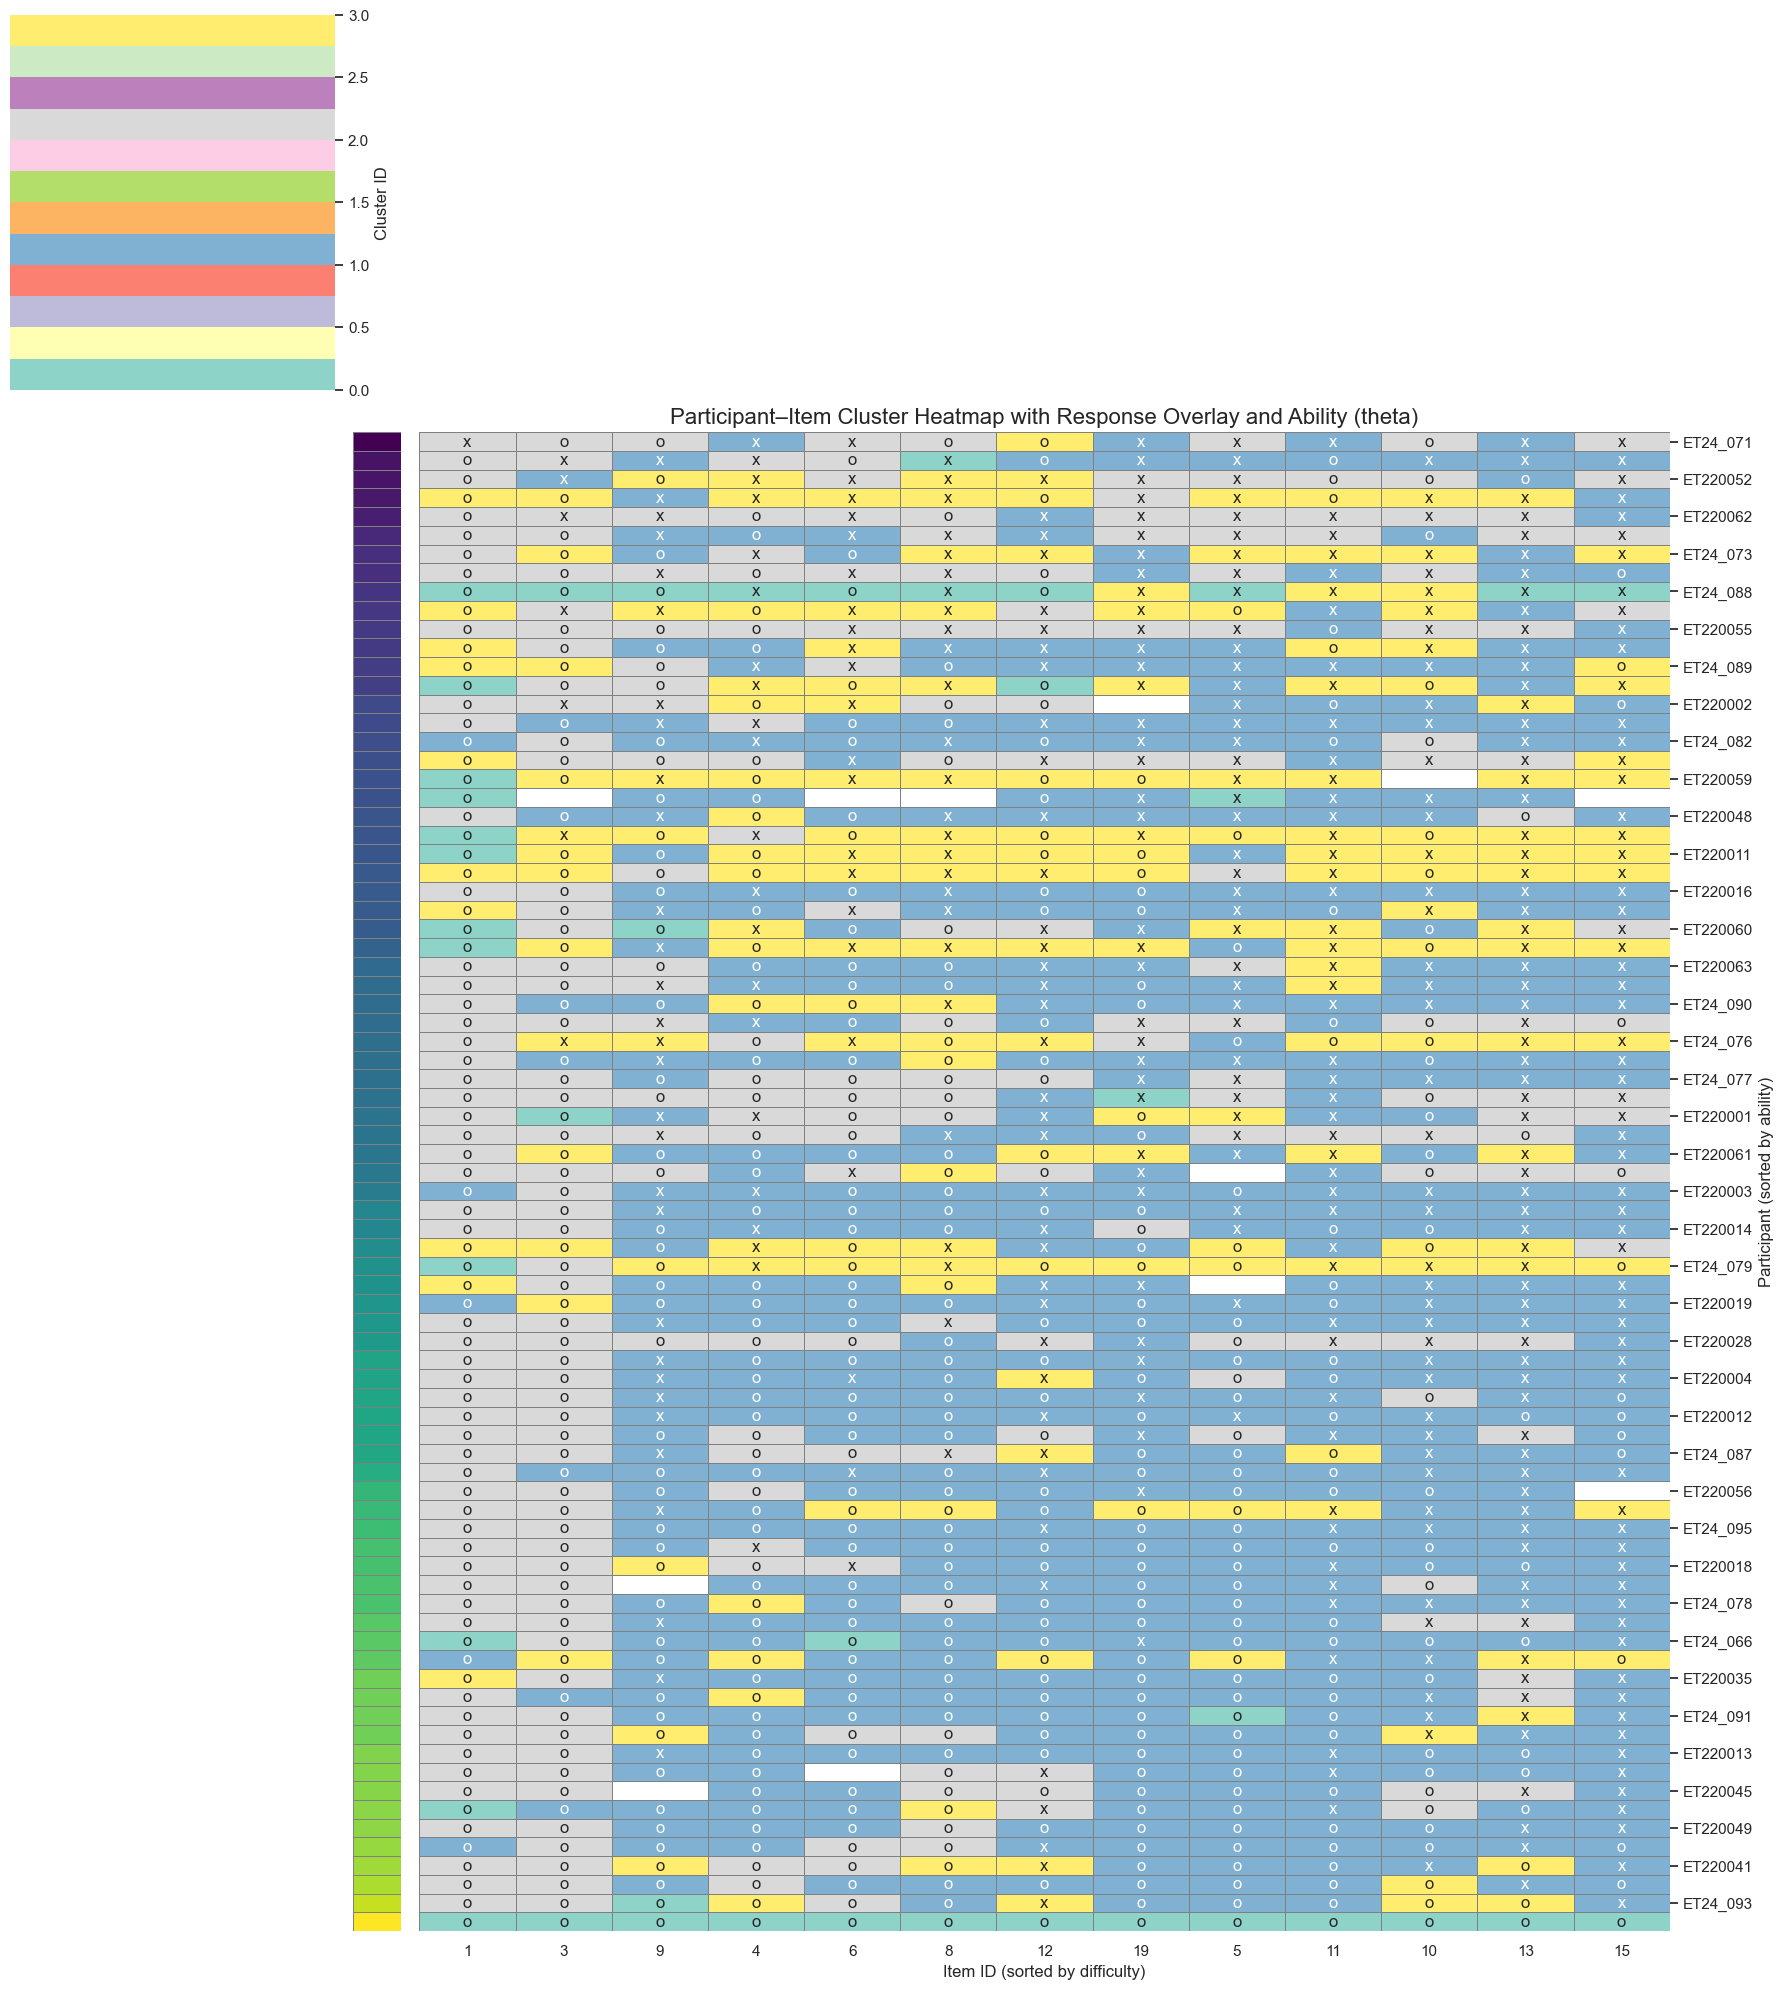

In [404]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Prepare data
heat_df = cluster_data.dropna(subset=['RECORDING_SESSION_LABEL', 'trialid', 'Cluster', 'response'])

# Step 2: Ensure Cluster is categorical (optional: sort levels)
heat_df['Cluster'] = heat_df['Cluster'].astype(str)  # ensure categorical format

# Step 3: Pivot cluster data
cluster_matrix = heat_df.pivot(index='RECORDING_SESSION_LABEL', columns='trialid', values='Cluster')

# Step 4: Pivot response data and convert to o or x
response_matrix = heat_df.pivot(index='RECORDING_SESSION_LABEL', columns='trialid', values='response')
annot_matrix = response_matrix.applymap(lambda x: "o" if x == 1 else ("x" if x == 0 else ""))

# Step 5: Order items by difficulty
item_difficulty = merged_df[['trialid', 'b']].drop_duplicates().set_index('trialid')['b']
sorted_items = item_difficulty.sort_values().index

# Align and convert cluster to integers for plotting
cluster_matrix = cluster_matrix[sorted_items]
cluster_matrix = cluster_matrix.applymap(lambda x: int(x) if pd.notna(x) else np.nan)  # convert to numeric
annot_matrix = annot_matrix[sorted_items]

# Step 6: Add ability info and sort rows
ability_df = merged_df[['RECORDING_SESSION_LABEL', 'theta']].drop_duplicates().set_index('RECORDING_SESSION_LABEL')
cluster_matrix = cluster_matrix.join(ability_df).sort_values(by='theta')
annot_matrix = annot_matrix.loc[cluster_matrix.index]
theta_sorted = cluster_matrix['theta']
cluster_matrix_sorted = cluster_matrix.drop(columns='theta')

# Step 7: Normalize theta for color bar
from matplotlib.colors import Normalize
norm = Normalize(vmin=theta_sorted.min(), vmax=theta_sorted.max())
theta_colors = sns.color_palette("viridis", as_cmap=True)(norm(theta_sorted.values))

# Step 8: Plot using clustermap (with row_colors)
sns.set(style="white")
g = sns.clustermap(
    cluster_matrix_sorted,
    annot=annot_matrix,
    fmt="",
    cmap="Set3",
    row_colors=theta_colors,
    col_cluster=False,
    row_cluster=False,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Cluster ID'},
    figsize=(18, min(0.4 * cluster_matrix_sorted.shape[0], 20))
)

g.ax_heatmap.set_title("Participant–Item Cluster Heatmap with Response Overlay and Ability (theta)", fontsize=16)
g.ax_heatmap.set_xlabel("Item ID (sorted by difficulty)")
g.ax_heatmap.set_ylabel("Participant (sorted by ability)")
plt.tight_layout()
plt.show()


### Unsupervised Anomaly Detection

### Engagement

In [388]:
merged_df['Engagement_Score'] = merged_df[[
    'FIXATION_COUNT_log',
    'AVERAGE_FIXATION_DURATION_log',
    'PUPIL_SIZE_MEAN',
    'RUN_COUNT_log',
    'DURATION_log'
]].apply(lambda x: (x - x.mean())/x.std()).mean(axis=1)

low_engagement = merged_df['Engagement_Score'].quantile(0.1)
merged_df['Low_Engagement_Flag'] = merged_df['Engagement_Score'] < low_engagement


### Detect Guessers (Low fixation, fast responding, low accuracy)

In [389]:
merged_df['Guessing_Score'] = merged_df[['FIXATION_COUNT_log', 'DURATION_log', 'response']].apply(
    lambda row: (row['FIXATION_COUNT_log'] + row['DURATION_log']) / 2 if row['response'] == 0 else np.nan, axis=1)

guessing_threshold = merged_df['Guessing_Score'].quantile(0.1)
merged_df['Guessing_Flag'] = merged_df['Guessing_Score'] < guessing_threshold


### Potential Cheating Detection (High accuracy, abnormal eye movement)

In [390]:
merged_df['EyeMovement_Score'] = merged_df[['AVERAGE_SACCADE_AMPLITUDE_sqrt', 'BLINK_COUNT_log']].apply(
    lambda x: (x - x.mean())/x.std()).mean(axis=1)

high_accuracy = merged_df['response'] == 1
abnormal_eye_movement = merged_df['EyeMovement_Score'].quantile(0.9)

merged_df['Cheating_Flag'] = (high_accuracy) & (merged_df['EyeMovement_Score'] > abnormal_eye_movement)


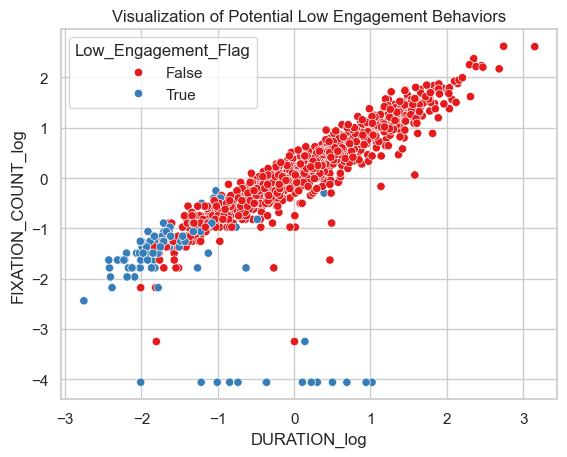

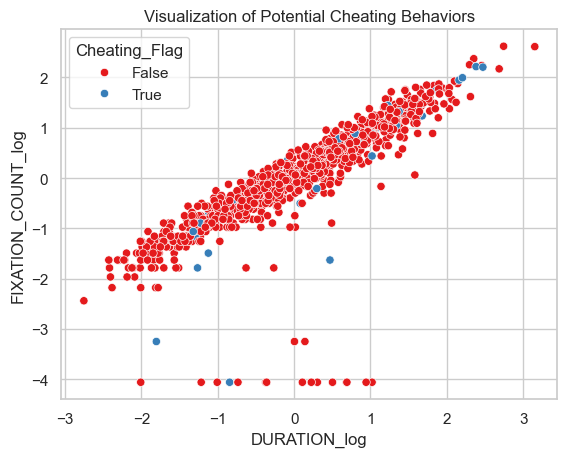

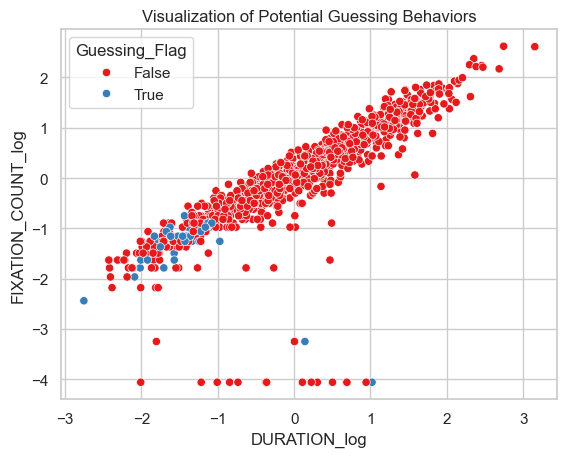

In [391]:
sns.scatterplot(data=merged_df, x='DURATION_log', y='FIXATION_COUNT_log',
                hue='Low_Engagement_Flag',
                palette='Set1')
plt.title("Visualization of Potential Low Engagement Behaviors")
plt.show()


sns.scatterplot(data=merged_df, x='DURATION_log', y='FIXATION_COUNT_log',
                hue='Cheating_Flag',
                palette='Set1')
plt.title("Visualization of Potential Cheating Behaviors")
plt.show()

sns.scatterplot(data=merged_df, x='DURATION_log', y='FIXATION_COUNT_log',
                hue='Guessing_Flag',
                palette='Set1')
plt.title("Visualization of Potential Guessing Behaviors")
plt.show()


###  UMAP Visualization

### Isolation Forest for Exploratory Anomaly Detection

In [394]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(df_standardized[after_cor_checking_vars])
df_standardized['cluster'] = cluster_labels


In [395]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(df_standardized[after_cor_checking_vars], df_standardized['cluster'])
feature_importances = rf.feature_importances_
feature_importances


array([0.03598865, 0.10462481, 0.06390375, 0.16326632, 0.15106535,
       0.09589369, 0.05615197, 0.12113321, 0.02651267, 0.18145957])

In [396]:
# Create a DataFrame to show importance
importance_df = pd.DataFrame({
    'Feature': after_cor_checking_vars,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)


                          Feature  Importance
9                 BLINK_COUNT_log    0.181460
3  AVERAGE_SACCADE_AMPLITUDE_sqrt    0.163266
4   MEDIAN_SACCADE_AMPLITUDE_sqrt    0.151065
7                  PUPIL_SIZE_MIN    0.121133
1              FIXATION_COUNT_log    0.104625
5            SD_SACCADE_AMPLITUDE    0.095894
2       FIXATION_DURATION_MIN_log    0.063904
6                 PUPIL_SIZE_MEAN    0.056152
0   AVERAGE_FIXATION_DURATION_log    0.035989
8      AVERAGE_BLINK_DURATION_log    0.026513
